# import libraries and prepare config

In [ ]:
import os, json
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting,  datasets, image
from nilearn.image import new_img_like, resample_to_img
from ipywidgets import  widgets
from IPython.display import Video, display, clear_output
import matplotlib.pyplot as plt
import ast
import string
import re
from pathlib import Path
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
import glob
import spacy
import fasttext
import fasttext.util
from gensim.utils import simple_preprocess
import gensim.downloader as api
from sklearn.model_selection import train_test_split 
import torch
from transformers import RobertaTokenizer, RobertaModel,  GPT2Tokenizer, GPT2Model

from utils import interface_display_transcript_and_brain, list_splits, interactive_brain_slicer

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 9.1 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 10.9 MB/s eta 0:00:01
     -------------------- ------------------- 6.6/12.8 MB 10.6 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 10.2 MB/s eta 0:00:01
     ------------------------------- ------- 10.5/12.8 MB 10.1 MB/s eta 0:00:01
     ------------------------------------- - 12.3/12.8 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

Using device: NVIDIA GeForce RTX 4050 Laptop GPU


# DATA EXPLORATION

* TR (Repetition Time) = the duration of one fMRI scan volume (1.49s in this dataset). 
* The fMRI responses are recorded one TR at a time, and the transcripts are pre-segmented into the same TR windows.
* This means that row i in the transcript corresponds directly to fMRI volume i in the brain data.

In [4]:
ts_path = 'data/friends_transcripts/s1/friends_s01e01a.tsv'
ts_ex = pd.read_csv(ts_path,  sep='\t')
print('\nTranscripts shape (n_tr x columns);', ts_ex.shape)


Transcripts shape (n_tr x columns); (591, 4)


In [5]:
print('first 20*1.49 seconds of text transcripts:')
ts_ex.head(20)

first 20*1.49 seconds of text transcripts:


,text_per_tr,words_per_tr,onsets_per_tr,durations_per_tr
0,NaN,[],[],[]
1,NaN,[],[],[]
2,NaN,[],[],[]
3,NaN,[],[],[]
4,NaN,[],[],[]
5,NaN,[],[],[]
6,NaN,[],[],[]
7,NaN,[],[],[]
8,NaN,[],[],[]
9,NaN,[],[],[]


fMRI measures the BOLD signal (blood oxygenation level dependent), not neural activity directly.
Because blood-flow changes peak 5–6 seconds after neurons fire, the fMRI volume at time t reflects neural events from a few seconds earlier.
For this reason, stimuli and fMRI data must be aligned using an HRF delay of several TRs.

In [6]:
interface_display_transcript_and_brain(
    transcript_path=ts_path,
    fmri_file_path='data/fmri/sub-01/func/sub-01_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5',
    atlas_path='data/fmri/sub-01/atlas/sub-01_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-dseg_parcellation.nii.gz',
    dataset_name="ses-003_task-s01e01a",
    hrf_delay=3
)

Dropdown(description='Select scene:', options=(('<No dialogue in this scene>', 0), ('<No dialogue in this scen…

Output()

In [7]:
root = 'data/friends_transcripts'

def load_tsv(path):
    df = pd.read_csv(path, sep="\t")
    
    # id like"s01e01a"
    base = os.path.basename(path)
    seg_id = os.path.splitext(base)[0].replace("friends_", "")  # friends_s01e01a -> s01e01a
    
    # parse words_per_tr in lista di parole
    def parse_words(x):
        if isinstance(x, list):
            return x
        if isinstance(x, float) and np.isnan(x):
            return []
        if isinstance(x, str):
            s = x.strip()
            if not s:
                return []
            if s.startswith("[") and s.endswith("]"):
                try:
                    out = ast.literal_eval(s)
                    if isinstance(out, list):
                        return out
                except Exception:
                    pass
            # fallback: split semplice
            return s.split()
        return []
    
    df["words_list"] = df["words_per_tr"].apply(parse_words)
    df["n_words"] = df["words_list"].apply(len)
    
    df["segment_id"] = seg_id
    df["tr_idx"] = np.arange(len(df))         
    df["n_tr_segment"] = len(df)             
    return df

In [8]:
tsv_paths = sorted(glob.glob(os.path.join(root, "s*", "friends_*.tsv")))
print(f"Found {len(tsv_paths)} episode clips (.tsv)")

all_tr_list = [load_tsv(p) for p in tsv_paths]
all_tr = pd.concat(all_tr_list, ignore_index=True)

h = round(all_tr.shape[0] * 1.49 / 60 / 60, 2)
print("Total number of TR:", all_tr.shape[0], f'equivalents to {h} hours of language transcripts')

Found 292 episode clips (.tsv)
Total number of TR: 137681 equivalents to 56.98 hours of language transcripts


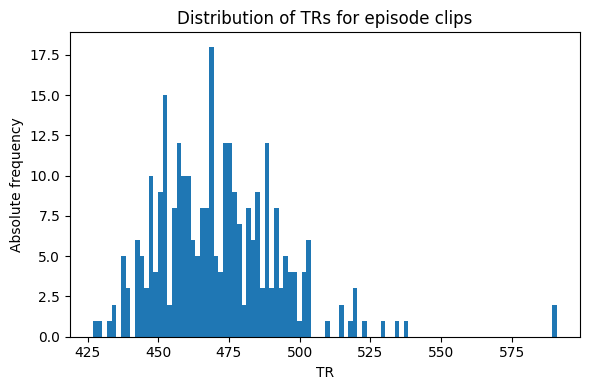

In [9]:
seg_len = all_tr.groupby("segment_id")["tr_idx"].max() + 1
#print(seg_len.describe())
plt.figure(figsize=(6,4))
plt.hist(seg_len, bins=100)
plt.xlabel("TR")
plt.ylabel("Absolute frequency")
plt.title("Distribution of TRs for episode clips")
plt.tight_layout()
plt.show()

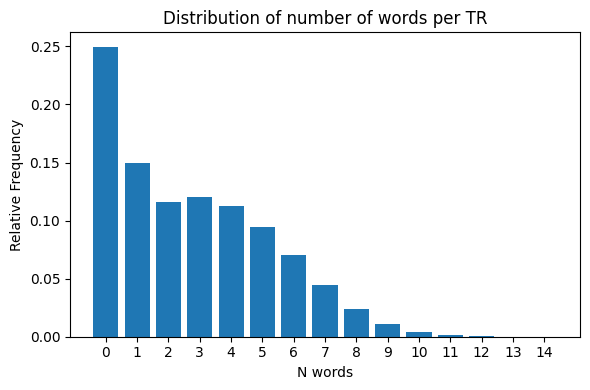

In [10]:
plt.figure(figsize=(6,4))
counts = all_tr["n_words"].value_counts(normalize=True).sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel("N words")
plt.ylabel("Relative Frequency")
plt.title("Distribution of number of words per TR")
plt.xticks(counts.index)
plt.tight_layout()
plt.show()


In [12]:
base_path = Path(root) 
seasons = [f"s{i}" for i in range(1,7)]

all_rows = []
for season in seasons:
    season_path = base_path/ season
    
    for tsv_file in sorted(season_path.glob("*.tsv")):
        df = pd.read_csv(tsv_file, sep="\t")
        
        # Femove NaN and get original index
        mask = df["text_per_tr"].notna()
        df_filtered = df.loc[mask, ["text_per_tr", "words_per_tr"]].copy()
        df_filtered["tr_index"] = df_filtered.index
        df_filtered["source_path"] = str(tsv_file)
        
        all_rows.append(df_filtered)

# df
df_all = pd.concat(all_rows, ignore_index=True)
df_all["words_per_tr"] = df_all["words_per_tr"].apply(ast.literal_eval)
df_all['season'] = df_all['source_path'].str.extract(r'\\(s\d+)\\')
df_all['episode'] = df_all['source_path'].str.extract(r'\\([^\\]+)\.tsv$')
df_all = df_all[["source_path", "tr_index", "text_per_tr", "words_per_tr", "season", "episode"]]
df_all['n_words'] = df_all['words_per_tr'].apply(len)
df_all 

,source_path,tr_index,text_per_tr,words_per_tr,season,episode,n_words
0,data\friends_transcripts\s1\friends_s01e01a.tsv,12,There's,[There's],s1,friends_s01e01a,1
1,data\friends_transcripts\s1\friends_s01e01a.tsv,13,nothing to tell.,"[nothing, to, tell.]",s1,friends_s01e01a,3
2,data\friends_transcripts\s1\friends_s01e01a.tsv,14,Just some guy I work,"[Just, some, guy, I, work]",s1,friends_s01e01a,5
3,data\friends_transcripts\s1\friends_s01e01a.tsv,15,"with. Come on,","[with., Come, on,]",s1,friends_s01e01a,3
4,data\friends_transcripts\s1\friends_s01e01a.tsv,16,you're going out with the guy.,"[you're, going, out, with, the, guy.]",s1,friends_s01e01a,6
...,...,...,...,...,...,...,...
103308,data\friends_transcripts\s6\friends_s06e24d.tsv,450,"Oh, no, wait.","[Oh,, no,, wait.]",s6,friends_s06e24d,3
103309,data\friends_transcripts\s6\friends_s06e24d.tsv,451,"No, this is wrong. Ross","[No,, this, is, wrong., Ross]",s6,friends_s06e24d,5
103310,data\friends_transcripts\s6\friends_s06e24d.tsv,452,isn't here.,"[isn't, here.]",s6,friends_s06e24d,2
103311,data\friends_transcripts\s6\friends_s06e24d.tsv,454,"Oh, hell, he's done this three","[Oh,, hell,, he's, done, this, three]",s6,friends_s06e24d,6


In [14]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def tokenize_clean(text):
    text_clean = text.translate(str.maketrans('', '', string.punctuation))
    return tokenizer.tokenize(text_clean)

df_all["tokens"] = df_all["text_per_tr"].apply(tokenize_clean)
df_all["n_tokens"] = df_all["tokens"].apply(len)

df_all.head(10)

,source_path,tr_index,text_per_tr,words_per_tr,season,episode,n_words,tokens,n_tokens
0,data\friends_transcripts\s1\friends_s01e01a.tsv,12,There's,[There's],s1,friends_s01e01a,1,"[The, res, Ġ]",3
1,data\friends_transcripts\s1\friends_s01e01a.tsv,13,nothing to tell.,"[nothing, to, tell.]",s1,friends_s01e01a,3,"[nothing, Ġto, Ġtell, Ġ]",4
2,data\friends_transcripts\s1\friends_s01e01a.tsv,14,Just some guy I work,"[Just, some, guy, I, work]",s1,friends_s01e01a,5,"[Just, Ġsome, Ġguy, ĠI, Ġwork, Ġ]",6
3,data\friends_transcripts\s1\friends_s01e01a.tsv,15,"with. Come on,","[with., Come, on,]",s1,friends_s01e01a,3,"[with, ĠCome, Ġon, Ġ]",4
4,data\friends_transcripts\s1\friends_s01e01a.tsv,16,you're going out with the guy.,"[you're, going, out, with, the, guy.]",s1,friends_s01e01a,6,"[you, re, Ġgoing, Ġout, Ġwith, Ġthe, Ġguy, Ġ]",8
5,data\friends_transcripts\s1\friends_s01e01a.tsv,17,There's got to be something wrong with,"[There's, got, to, be, something, wrong, with]",s1,friends_s01e01a,7,"[The, res, Ġgot, Ġto, Ġbe, Ġsomething, Ġwrong,...",9
6,data\friends_transcripts\s1\friends_s01e01a.tsv,18,"him. All right,","[him., All, right,]",s1,friends_s01e01a,3,"[him, ĠAll, Ġright, Ġ]",4
7,data\friends_transcripts\s1\friends_s01e01a.tsv,19,"joey, be nice.","[joey,, be, nice.]",s1,friends_s01e01a,3,"[j, oe, y, Ġbe, Ġnice, Ġ]",6
8,data\friends_transcripts\s1\friends_s01e01a.tsv,20,So does he have a hump? A,"[So, does, he, have, a, hump?, A]",s1,friends_s01e01a,7,"[So, Ġdoes, Ġhe, Ġhave, Ġa, Ġhump, ĠA, Ġ]",8
9,data\friends_transcripts\s1\friends_s01e01a.tsv,21,hump and a hairpiece.,"[hump, and, a, hairpiece.]",s1,friends_s01e01a,4,"[h, ump, Ġand, Ġa, Ġhair, piece, Ġ]",7


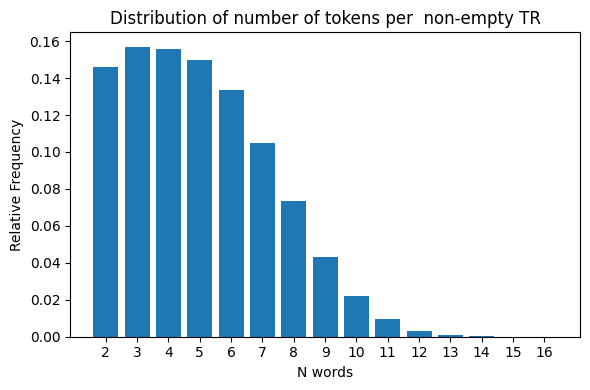

In [15]:
plt.figure(figsize=(6,4))
counts = df_all["n_tokens"].value_counts(normalize=True).sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel("N words")
plt.ylabel("Relative Frequency")
plt.title("Distribution of number of tokens per  non-empty TR")
plt.xticks(counts.index)
plt.tight_layout()
plt.show()

# ISOLATE LANGUAGE STRUCTURES

In [28]:
outdir = 'data/fedorendo_mask_language'
os.makedirs(outdir, exist_ok=True)

In [29]:
# Download Schaefer-1000 atlas
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=1)
sch_img = nib.load(schaefer.maps)
sch_data = sch_img.get_fdata()

# Load your Fedorenko
fed_img = nib.load('allParcels-language-SN220.nii')

# Resample Fedorenko to Schaefer space
fed_resampled = resample_to_img(fed_img, sch_img, interpolation='nearest')
fed_data = fed_resampled.get_fdata()

# Calculate overlap
fed_rois = np.unique(fed_data)[1:6]  # Skip background
mapping = {}

for fed_roi in fed_rois:
    fed_mask = (fed_data == fed_roi)
    overlapping = []
    
    for sch_id in range(1, 1001):  # Schaefer IDs: 1-1000
        sch_mask = (sch_data == sch_id)
        overlap_ratio = np.sum(fed_mask & sch_mask) / np.sum(sch_mask)
        
        if overlap_ratio > 0.05:
            overlapping.append(sch_id)
    
    mapping[int(fed_roi)] = overlapping
    print(f"Fed ROI {int(fed_roi)}: {len(overlapping)} parcels")

[fetch_atlas_schaefer_2018] Dataset found in C:\Users\andre\nilearn_data\schaefer_2018

C:\Users\andre\AppData\Local\Temp\ipykernel_20924\1133966775.py:10: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  fed_resampled = resample_to_img(fed_img, sch_img, interpolation='nearest')
C:\Users\andre\AppData\Local\Temp\ipykernel_20924\1133966775.py:10: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  fed_resampled = resample_to_img(fed_img, sch_img, interpolation='nearest')


Fed ROI 1: 6 parcels
Fed ROI 2: 11 parcels
Fed ROI 3: 7 parcels
Fed ROI 4: 17 parcels
Fed ROI 5: 40 parcels


In [30]:
rename = {
    1: "LH_IFGorb",
    2: "LH_IFG",
    3: "LH_MFG", 
    4: "LH_AntTemp",
    5: "LH_PostTemp",
}

mapping_ren = {
    rename.get(key, key): value 
    for key, value in mapping.items()
}

with open(os.path.join(outdir, 'mapping_fedorenko.json'), 'w', encoding='utf-8') as f:
    json.dump(mapping_ren, f, indent=4)

In [31]:
all_roi_ids = []
for roi_name, indices in mapping_ren.items():
    all_roi_ids.extend(indices)

# binary mask
parcel_ids = np.array(all_roi_ids)
mask_data = np.isin(sch_data, parcel_ids).astype(np.int16)
mask_img = new_img_like(sch_img, mask_data)

mask_path = os.path.join(outdir, "language_mask_fedorenko.nii.gz")
mask_img.to_filename(mask_path)

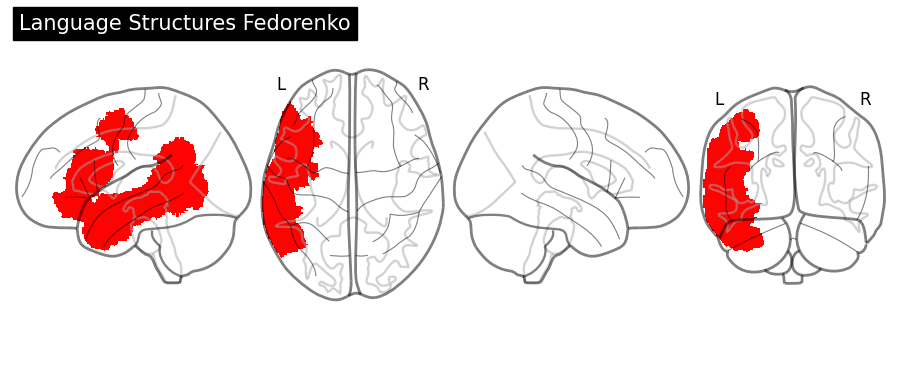

In [32]:
display = plotting.plot_glass_brain(
    mask_img, 
    display_mode='lzry',
    cmap='red_transparent',
    colorbar=False,
    plot_abs=False,
    threshold=0.5, 
    title='Language Structures Fedorenko',
    black_bg=False, 
    alpha=0.5  
)

In [33]:
interactive_brain_slicer(
    mask_path=mask_path,
        bg_template='mni152', 
    cmap='autumn',
    alpha=0.7,
    title='Language mask (Schaefer-1000 overlap)'
)

In [34]:
for roi_name, indices in mapping_ren.items():
    
    parcel_ids = np.array(indices)
    mask_data = np.isin(sch_data, parcel_ids).astype(np.int16)
    mask_img = new_img_like(sch_img, mask_data)
    
    
    mask_path = os.path.join(outdir, f"language_mask_{roi_name}.nii.gz")
    mask_img.to_filename(mask_path)
    
    
    display = plotting.plot_glass_brain(
        mask_img,
        display_mode='lzry',
        cmap='red_transparent',
        colorbar=False,
        plot_abs=False,
        threshold=0.5,
        title=f'Language Structure: {roi_name}',
        black_bg=False,
        alpha=0.5
    )
    
    # Saave ploy
    plot_path = os.path.join(outdir, f"plot_{roi_name}.png")
    display.savefig(plot_path, dpi=300)
    display.close()  
    
    print(f"Saved: {roi_name}")

Saved: LH_IFGorb
Saved: LH_IFG
Saved: LH_MFG
Saved: LH_AntTemp
Saved: LH_PostTemp


# WORD EMBEDDING EXTRACTION

## FastText

In [9]:
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

In [ ]:
def preprocess(text, model, model_type): 
   # Tokenize
    tokens = simple_preprocess(text, min_len=1, max_len=100)
    
    if len(tokens) == 0:
        return None
    
    embeddings = []
 
    if model_type == 'fasttext':
        # FastText: automatically handles OOV with subword info
        for token in tokens:
            embeddings.append(model[token])
            
    elif model_type == 'word2vec':
        mean_embedding = model.vectors.mean(axis=0)
        
        for token in tokens:
            if token in model:
                embeddings.append(mean_embedding)
            else:
                embeddings.append(mean_embedding) # handle OOV using mean embedding
                #print(token)
            
    
    
    return np.array(embeddings)

In [10]:
def extract_language_features_fasttext(split, model, save_dir):
    """Extract and save FastText embeddings for each TR.
    
    Parameters
    ----------
    split : str
        Movie split identifier (e.g., 'friends_s01e01a').
    model : gensim.models.KeyedVectors
        Pre-trained FastText model.
    save_dir : str
        Save directory.
    """
    
    os.makedirs(save_dir, exist_ok=True)
    season_pattern = r's0*(\d+)'
    match = re.search(season_pattern, split)
    season = 's' + match.group(1)
    stim_path = os.path.join('data', 'friends_transcripts', season, split+'.tsv')
    
    ### Read the transcripts ###
    df = pd.read_csv(stim_path, sep='\t')
    df.insert(loc=0, column="is_na", value=df["text_per_tr"].isna())
    
    ### Empty feature array ###
    n_trs = df.shape[0]
    embedding_dim = 300
    pooling_dim = embedding_dim * 2  # mean + max = 600
    
    # Preallocate array: (n_TRs, 600)
    all_features = np.full((n_trs, pooling_dim), np.nan, dtype=np.float32)
    
    ### Loop over text chunks ###
    for i in tqdm(range(df.shape[0]), desc=f"Processing {split} (FastText)"):
        
        if not df.iloc[i]["is_na"]:
            tr_text = df.iloc[i]["text_per_tr"]
            
            # Get embeddings for this TR
            embeddings = preprocess(tr_text, model, 'fasttext')
            
            if embeddings is not None and len(embeddings) > 0:
                # Pooling strategies
                mean_pool = np.mean(embeddings, axis=0)  # (300,)
                max_pool = np.max(embeddings, axis=0)    # (300,)
                
                # Concatenate
                pooled = np.concatenate([mean_pool, max_pool], axis=0)  # (600,)
                
                all_features[i, :] = pooled.astype(np.float32)
    
    ### Save the features ###
    out_file = os.path.join(save_dir, f'friends_{season}_fasttext_embeddings.h5')
    flag = 'a' if Path(out_file).exists() else 'w'
    
    with h5py.File(out_file, flag) as f:
        if split in f:
            del f[split]
        
        group = f.create_group(split)
        group.create_dataset('embeddings', data=all_features, dtype=np.float32)
    
    print(f"Saved {split} FastText features with shape {all_features.shape}")
    
    return all_features

### Extract

In [11]:
splits = list_splits('s1')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s01e01a (FastText): 100%|██████████| 591/591 [00:00<00:00, 12486.95it/s]


Saved friends_s01e01a FastText features with shape (591, 600)


Processing friends_s01e01b (FastText): 100%|██████████| 590/590 [00:00<00:00, 16588.28it/s]


Saved friends_s01e01b FastText features with shape (590, 600)


Processing friends_s01e02a (FastText): 100%|██████████| 482/482 [00:00<00:00, 9693.12it/s]


Saved friends_s01e02a FastText features with shape (482, 600)


Processing friends_s01e02b (FastText): 100%|██████████| 482/482 [00:00<00:00, 14712.57it/s]


Saved friends_s01e02b FastText features with shape (482, 600)


Processing friends_s01e03a (FastText): 100%|██████████| 472/472 [00:00<00:00, 9344.39it/s]


Saved friends_s01e03a FastText features with shape (472, 600)


Processing friends_s01e03b (FastText): 100%|██████████| 471/471 [00:00<00:00, 9354.39it/s]


Saved friends_s01e03b FastText features with shape (471, 600)


Processing friends_s01e04a (FastText): 100%|██████████| 502/502 [00:00<00:00, 14928.36it/s]


Saved friends_s01e04a FastText features with shape (502, 600)


Processing friends_s01e04b (FastText): 100%|██████████| 502/502 [00:00<00:00, 14871.53it/s]

Saved friends_s01e04b FastText features with shape (502, 600)



Processing friends_s01e05a (FastText): 100%|██████████| 468/468 [00:00<00:00, 14005.25it/s]


Saved friends_s01e05a FastText features with shape (468, 600)


Processing friends_s01e05b (FastText): 100%|██████████| 468/468 [00:00<00:00, 11305.92it/s]


Saved friends_s01e05b FastText features with shape (468, 600)


Processing friends_s01e06a (FastText): 100%|██████████| 488/488 [00:00<00:00, 9652.63it/s]


Saved friends_s01e06a FastText features with shape (488, 600)


Processing friends_s01e06b (FastText): 100%|██████████| 488/488 [00:00<00:00, 11069.10it/s]


Saved friends_s01e06b FastText features with shape (488, 600)


Processing friends_s01e07a (FastText): 100%|██████████| 492/492 [00:00<00:00, 12411.50it/s]


Saved friends_s01e07a FastText features with shape (492, 600)


Processing friends_s01e07b (FastText): 100%|██████████| 492/492 [00:00<00:00, 13763.01it/s]


Saved friends_s01e07b FastText features with shape (492, 600)


Processing friends_s01e08a (FastText): 100%|██████████| 475/475 [00:00<00:00, 12131.71it/s]


Saved friends_s01e08a FastText features with shape (475, 600)


Processing friends_s01e08b (FastText): 100%|██████████| 475/475 [00:00<00:00, 12299.94it/s]


Saved friends_s01e08b FastText features with shape (475, 600)


Processing friends_s01e09a (FastText): 100%|██████████| 467/467 [00:00<00:00, 11423.69it/s]


Saved friends_s01e09a FastText features with shape (467, 600)


Processing friends_s01e09b (FastText): 100%|██████████| 467/467 [00:00<00:00, 12412.88it/s]


Saved friends_s01e09b FastText features with shape (467, 600)


Processing friends_s01e10a (FastText): 100%|██████████| 495/495 [00:00<00:00, 14428.64it/s]


Saved friends_s01e10a FastText features with shape (495, 600)


Processing friends_s01e10b (FastText): 100%|██████████| 495/495 [00:00<00:00, 11181.08it/s]


Saved friends_s01e10b FastText features with shape (495, 600)


Processing friends_s01e11a (FastText): 100%|██████████| 476/476 [00:00<00:00, 11784.67it/s]


Saved friends_s01e11a FastText features with shape (476, 600)


Processing friends_s01e11b (FastText): 100%|██████████| 476/476 [00:00<00:00, 7234.07it/s]


Saved friends_s01e11b FastText features with shape (476, 600)


Processing friends_s01e12a (FastText): 100%|██████████| 471/471 [00:00<00:00, 11017.39it/s]


Saved friends_s01e12a FastText features with shape (471, 600)


Processing friends_s01e12b (FastText): 100%|██████████| 471/471 [00:00<00:00, 10989.50it/s]


Saved friends_s01e12b FastText features with shape (471, 600)


Processing friends_s01e13a (FastText): 100%|██████████| 468/468 [00:00<00:00, 10990.30it/s]


Saved friends_s01e13a FastText features with shape (468, 600)


Processing friends_s01e13b (FastText): 100%|██████████| 467/467 [00:00<00:00, 10870.84it/s]


Saved friends_s01e13b FastText features with shape (467, 600)


Processing friends_s01e14a (FastText): 100%|██████████| 491/491 [00:00<00:00, 12207.20it/s]


Saved friends_s01e14a FastText features with shape (491, 600)


Processing friends_s01e14b (FastText): 100%|██████████| 491/491 [00:00<00:00, 11320.75it/s]


Saved friends_s01e14b FastText features with shape (491, 600)


Processing friends_s01e15a (FastText): 100%|██████████| 476/476 [00:00<00:00, 7423.05it/s]


Saved friends_s01e15a FastText features with shape (476, 600)


Processing friends_s01e15b (FastText): 100%|██████████| 476/476 [00:00<00:00, 10808.83it/s]


Saved friends_s01e15b FastText features with shape (476, 600)


Processing friends_s01e16a (FastText): 100%|██████████| 482/482 [00:00<00:00, 9984.91it/s]


Saved friends_s01e16a FastText features with shape (482, 600)


Processing friends_s01e16b (FastText): 100%|██████████| 482/482 [00:00<00:00, 11204.21it/s]


Saved friends_s01e16b FastText features with shape (482, 600)


Processing friends_s01e17a (FastText): 100%|██████████| 482/482 [00:00<00:00, 10155.80it/s]


Saved friends_s01e17a FastText features with shape (482, 600)


Processing friends_s01e17b (FastText): 100%|██████████| 482/482 [00:00<00:00, 12572.32it/s]


Saved friends_s01e17b FastText features with shape (482, 600)


Processing friends_s01e18a (FastText): 100%|██████████| 496/496 [00:00<00:00, 11779.02it/s]


Saved friends_s01e18a FastText features with shape (496, 600)


Processing friends_s01e18b (FastText): 100%|██████████| 496/496 [00:00<00:00, 12029.67it/s]


Saved friends_s01e18b FastText features with shape (496, 600)


Processing friends_s01e19a (FastText): 100%|██████████| 460/460 [00:00<00:00, 8612.80it/s]


Saved friends_s01e19a FastText features with shape (460, 600)


Processing friends_s01e19b (FastText): 100%|██████████| 460/460 [00:00<00:00, 10611.95it/s]


Saved friends_s01e19b FastText features with shape (460, 600)


Processing friends_s01e20a (FastText): 100%|██████████| 460/460 [00:00<00:00, 11256.79it/s]


Saved friends_s01e20a FastText features with shape (460, 600)


Processing friends_s01e20b (FastText): 100%|██████████| 460/460 [00:00<00:00, 10943.23it/s]


Saved friends_s01e20b FastText features with shape (460, 600)


Processing friends_s01e21a (FastText): 100%|██████████| 476/476 [00:00<00:00, 10899.71it/s]


Saved friends_s01e21a FastText features with shape (476, 600)


Processing friends_s01e21b (FastText): 100%|██████████| 476/476 [00:00<00:00, 11637.60it/s]


Saved friends_s01e21b FastText features with shape (476, 600)


Processing friends_s01e22a (FastText): 100%|██████████| 473/473 [00:00<00:00, 12270.27it/s]


Saved friends_s01e22a FastText features with shape (473, 600)


Processing friends_s01e22b (FastText): 100%|██████████| 473/473 [00:00<00:00, 11507.04it/s]


Saved friends_s01e22b FastText features with shape (473, 600)


Processing friends_s01e23a (FastText): 100%|██████████| 461/461 [00:00<00:00, 11151.91it/s]


Saved friends_s01e23a FastText features with shape (461, 600)


Processing friends_s01e23b (FastText): 100%|██████████| 461/461 [00:00<00:00, 12479.74it/s]


Saved friends_s01e23b FastText features with shape (461, 600)


Processing friends_s01e24a (FastText): 100%|██████████| 514/514 [00:00<00:00, 11245.37it/s]


Saved friends_s01e24a FastText features with shape (514, 600)


Processing friends_s01e24b (FastText): 100%|██████████| 514/514 [00:00<00:00, 14151.71it/s]

Saved friends_s01e24b FastText features with shape (514, 600)


In [12]:
splits = list_splits('s2')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s02e01a (FastText): 100%|██████████| 476/476 [00:00<00:00, 8416.69it/s]


Saved friends_s02e01a FastText features with shape (476, 600)


Processing friends_s02e01b (FastText): 100%|██████████| 476/476 [00:00<00:00, 11335.12it/s]


Saved friends_s02e01b FastText features with shape (476, 600)


Processing friends_s02e02a (FastText): 100%|██████████| 450/450 [00:00<00:00, 11957.00it/s]


Saved friends_s02e02a FastText features with shape (450, 600)


Processing friends_s02e02b (FastText): 100%|██████████| 450/450 [00:00<00:00, 21125.26it/s]


Saved friends_s02e02b FastText features with shape (450, 600)


Processing friends_s02e03a (FastText): 100%|██████████| 464/464 [00:00<00:00, 9165.55it/s]


Saved friends_s02e03a FastText features with shape (464, 600)


Processing friends_s02e03b (FastText): 100%|██████████| 464/464 [00:00<00:00, 9181.94it/s]


Saved friends_s02e03b FastText features with shape (464, 600)


Processing friends_s02e04a (FastText): 100%|██████████| 453/453 [00:00<00:00, 13404.21it/s]

Saved friends_s02e04a FastText features with shape (453, 600)



Processing friends_s02e04b (FastText): 100%|██████████| 453/453 [00:00<00:00, 11674.40it/s]


Saved friends_s02e04b FastText features with shape (453, 600)


Processing friends_s02e05a (FastText): 100%|██████████| 454/454 [00:00<00:00, 9126.79it/s]


Saved friends_s02e05a FastText features with shape (454, 600)


Processing friends_s02e05b (FastText): 100%|██████████| 454/454 [00:00<00:00, 13393.17it/s]


Saved friends_s02e05b FastText features with shape (454, 600)


Processing friends_s02e06a (FastText): 100%|██████████| 499/499 [00:00<00:00, 9920.78it/s]


Saved friends_s02e06a FastText features with shape (499, 600)


Processing friends_s02e06b (FastText): 100%|██████████| 499/499 [00:00<00:00, 10063.22it/s]


Saved friends_s02e06b FastText features with shape (499, 600)


Processing friends_s02e07a (FastText): 100%|██████████| 495/495 [00:00<00:00, 13376.59it/s]


Saved friends_s02e07a FastText features with shape (495, 600)


Processing friends_s02e07b (FastText): 100%|██████████| 495/495 [00:00<00:00, 14706.22it/s]


Saved friends_s02e07b FastText features with shape (495, 600)


Processing friends_s02e08a (FastText): 100%|██████████| 457/457 [00:00<00:00, 9854.03it/s]


Saved friends_s02e08a FastText features with shape (457, 600)


Processing friends_s02e08b (FastText): 100%|██████████| 457/457 [00:00<00:00, 13602.70it/s]


Saved friends_s02e08b FastText features with shape (457, 600)


Processing friends_s02e09a (FastText): 100%|██████████| 451/451 [00:00<00:00, 16224.36it/s]


Saved friends_s02e09a FastText features with shape (451, 600)


Processing friends_s02e09b (FastText): 100%|██████████| 451/451 [00:00<00:00, 13426.20it/s]


Saved friends_s02e09b FastText features with shape (451, 600)


Processing friends_s02e10a (FastText): 100%|██████████| 478/478 [00:00<00:00, 8452.37it/s]


Saved friends_s02e10a FastText features with shape (478, 600)


Processing friends_s02e10b (FastText): 100%|██████████| 478/478 [00:00<00:00, 8874.08it/s]


Saved friends_s02e10b FastText features with shape (478, 600)


Processing friends_s02e11a (FastText): 100%|██████████| 487/487 [00:00<00:00, 9528.95it/s]


Saved friends_s02e11a FastText features with shape (487, 600)


Processing friends_s02e11b (FastText): 100%|██████████| 487/487 [00:00<00:00, 12741.01it/s]


Saved friends_s02e11b FastText features with shape (487, 600)


Processing friends_s02e12a (FastText): 100%|██████████| 488/488 [00:00<00:00, 10691.15it/s]


Saved friends_s02e12a FastText features with shape (488, 600)


Processing friends_s02e12b (FastText): 100%|██████████| 488/488 [00:00<00:00, 11804.45it/s]


Saved friends_s02e12b FastText features with shape (488, 600)


Processing friends_s02e13a (FastText): 100%|██████████| 488/488 [00:00<00:00, 2992.81it/s]


Saved friends_s02e13a FastText features with shape (488, 600)


Processing friends_s02e13b (FastText): 100%|██████████| 488/488 [00:00<00:00, 2981.90it/s]


Saved friends_s02e13b FastText features with shape (488, 600)


Processing friends_s02e14a (FastText): 100%|██████████| 473/473 [00:00<00:00, 2096.17it/s]


Saved friends_s02e14a FastText features with shape (473, 600)


Processing friends_s02e14b (FastText): 100%|██████████| 473/473 [00:00<00:00, 2798.31it/s]


Saved friends_s02e14b FastText features with shape (473, 600)


Processing friends_s02e15a (FastText): 100%|██████████| 465/465 [00:00<00:00, 2661.03it/s]


Saved friends_s02e15a FastText features with shape (465, 600)


Processing friends_s02e15b (FastText): 100%|██████████| 465/465 [00:00<00:00, 2769.39it/s]


Saved friends_s02e15b FastText features with shape (465, 600)


Processing friends_s02e16a (FastText): 100%|██████████| 477/477 [00:00<00:00, 2127.10it/s]


Saved friends_s02e16a FastText features with shape (477, 600)


Processing friends_s02e16b (FastText): 100%|██████████| 477/477 [00:00<00:00, 2446.70it/s]


Saved friends_s02e16b FastText features with shape (477, 600)


Processing friends_s02e17a (FastText): 100%|██████████| 488/488 [00:00<00:00, 2329.27it/s]


Saved friends_s02e17a FastText features with shape (488, 600)


Processing friends_s02e17b (FastText): 100%|██████████| 488/488 [00:00<00:00, 2723.72it/s]


Saved friends_s02e17b FastText features with shape (488, 600)


Processing friends_s02e18a (FastText): 100%|██████████| 459/459 [00:00<00:00, 1598.26it/s]


Saved friends_s02e18a FastText features with shape (459, 600)


Processing friends_s02e18b (FastText): 100%|██████████| 459/459 [00:00<00:00, 2701.82it/s]


Saved friends_s02e18b FastText features with shape (459, 600)


Processing friends_s02e19a (FastText): 100%|██████████| 477/477 [00:00<00:00, 2206.31it/s]


Saved friends_s02e19a FastText features with shape (477, 600)


Processing friends_s02e19b (FastText): 100%|██████████| 477/477 [00:00<00:00, 2256.74it/s]


Saved friends_s02e19b FastText features with shape (477, 600)


Processing friends_s02e20a (FastText): 100%|██████████| 448/448 [00:00<00:00, 2057.78it/s]


Saved friends_s02e20a FastText features with shape (448, 600)


Processing friends_s02e20b (FastText): 100%|██████████| 448/448 [00:00<00:00, 2205.90it/s]


Saved friends_s02e20b FastText features with shape (448, 600)


Processing friends_s02e21a (FastText): 100%|██████████| 469/469 [00:00<00:00, 2884.87it/s]


Saved friends_s02e21a FastText features with shape (469, 600)


Processing friends_s02e21b (FastText): 100%|██████████| 469/469 [00:00<00:00, 2197.58it/s]


Saved friends_s02e21b FastText features with shape (469, 600)


Processing friends_s02e22a (FastText): 100%|██████████| 452/452 [00:00<00:00, 2071.30it/s]


Saved friends_s02e22a FastText features with shape (452, 600)


Processing friends_s02e22b (FastText): 100%|██████████| 452/452 [00:00<00:00, 2701.61it/s]


Saved friends_s02e22b FastText features with shape (452, 600)


Processing friends_s02e23a (FastText): 100%|██████████| 455/455 [00:00<00:00, 2401.86it/s]


Saved friends_s02e23a FastText features with shape (455, 600)


Processing friends_s02e23b (FastText): 100%|██████████| 455/455 [00:00<00:00, 2607.91it/s]


Saved friends_s02e23b FastText features with shape (455, 600)


Processing friends_s02e24a (FastText): 100%|██████████| 468/468 [00:00<00:00, 2257.08it/s]


Saved friends_s02e24a FastText features with shape (468, 600)


Processing friends_s02e24b (FastText): 100%|██████████| 468/468 [00:00<00:00, 2606.98it/s]


Saved friends_s02e24b FastText features with shape (468, 600)


In [13]:
splits = list_splits('s3')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s03e01a (FastText):   0%|          | 0/490 [00:00<?, ?it/s]

Processing friends_s03e01a (FastText): 100%|██████████| 490/490 [00:00<00:00, 2201.82it/s]


Saved friends_s03e01a FastText features with shape (490, 600)


Processing friends_s03e01b (FastText): 100%|██████████| 490/490 [00:00<00:00, 2386.22it/s]


Saved friends_s03e01b FastText features with shape (490, 600)


Processing friends_s03e02a (FastText): 100%|██████████| 474/474 [00:00<00:00, 1948.26it/s]


Saved friends_s03e02a FastText features with shape (474, 600)


Processing friends_s03e02b (FastText): 100%|██████████| 474/474 [00:00<00:00, 2263.11it/s]


Saved friends_s03e02b FastText features with shape (474, 600)


Processing friends_s03e03a (FastText): 100%|██████████| 453/453 [00:00<00:00, 2025.29it/s]


Saved friends_s03e03a FastText features with shape (453, 600)


Processing friends_s03e03b (FastText): 100%|██████████| 453/453 [00:00<00:00, 2420.14it/s]


Saved friends_s03e03b FastText features with shape (453, 600)


Processing friends_s03e04a (FastText): 100%|██████████| 473/473 [00:00<00:00, 2138.70it/s]


Saved friends_s03e04a FastText features with shape (473, 600)


Processing friends_s03e04b (FastText): 100%|██████████| 472/472 [00:00<00:00, 1980.09it/s]


Saved friends_s03e04b FastText features with shape (472, 600)


Processing friends_s03e05a (FastText): 100%|██████████| 483/483 [00:00<00:00, 2174.57it/s]


Saved friends_s03e05a FastText features with shape (483, 600)


Processing friends_s03e05b (FastText): 100%|██████████| 483/483 [00:00<00:00, 1957.84it/s]


Saved friends_s03e05b FastText features with shape (483, 600)


Processing friends_s03e06a (FastText): 100%|██████████| 469/469 [00:00<00:00, 2542.92it/s]


Saved friends_s03e06a FastText features with shape (469, 600)


Processing friends_s03e06b (FastText): 100%|██████████| 469/469 [00:00<00:00, 2456.02it/s]


Saved friends_s03e06b FastText features with shape (469, 600)


Processing friends_s03e07a (FastText): 100%|██████████| 466/466 [00:00<00:00, 2415.64it/s]


Saved friends_s03e07a FastText features with shape (466, 600)


Processing friends_s03e07b (FastText): 100%|██████████| 466/466 [00:00<00:00, 2077.49it/s]


Saved friends_s03e07b FastText features with shape (466, 600)


Processing friends_s03e08a (FastText): 100%|██████████| 459/459 [00:00<00:00, 1877.63it/s]


Saved friends_s03e08a FastText features with shape (459, 600)


Processing friends_s03e08b (FastText): 100%|██████████| 459/459 [00:00<00:00, 1905.19it/s]


Saved friends_s03e08b FastText features with shape (459, 600)


Processing friends_s03e09a (FastText): 100%|██████████| 492/492 [00:00<00:00, 2039.72it/s]


Saved friends_s03e09a FastText features with shape (492, 600)


Processing friends_s03e09b (FastText): 100%|██████████| 492/492 [00:00<00:00, 2544.70it/s]


Saved friends_s03e09b FastText features with shape (492, 600)


Processing friends_s03e10a (FastText): 100%|██████████| 450/450 [00:00<00:00, 2333.91it/s]


Saved friends_s03e10a FastText features with shape (450, 600)


Processing friends_s03e10b (FastText): 100%|██████████| 450/450 [00:00<00:00, 2342.54it/s]


Saved friends_s03e10b FastText features with shape (450, 600)


Processing friends_s03e11a (FastText): 100%|██████████| 456/456 [00:00<00:00, 2194.71it/s]


Saved friends_s03e11a FastText features with shape (456, 600)


Processing friends_s03e11b (FastText): 100%|██████████| 456/456 [00:00<00:00, 2394.39it/s]


Saved friends_s03e11b FastText features with shape (456, 600)


Processing friends_s03e12a (FastText): 100%|██████████| 463/463 [00:00<00:00, 2384.92it/s]


Saved friends_s03e12a FastText features with shape (463, 600)


Processing friends_s03e12b (FastText): 100%|██████████| 463/463 [00:00<00:00, 2412.28it/s]


Saved friends_s03e12b FastText features with shape (463, 600)


Processing friends_s03e13a (FastText): 100%|██████████| 473/473 [00:00<00:00, 2435.94it/s]


Saved friends_s03e13a FastText features with shape (473, 600)


Processing friends_s03e13b (FastText): 100%|██████████| 473/473 [00:00<00:00, 2415.39it/s]


Saved friends_s03e13b FastText features with shape (473, 600)


Processing friends_s03e14a (FastText): 100%|██████████| 458/458 [00:00<00:00, 2399.73it/s]


Saved friends_s03e14a FastText features with shape (458, 600)


Processing friends_s03e14b (FastText): 100%|██████████| 458/458 [00:00<00:00, 2201.88it/s]


Saved friends_s03e14b FastText features with shape (458, 600)


Processing friends_s03e15a (FastText): 100%|██████████| 457/457 [00:00<00:00, 2272.59it/s]


Saved friends_s03e15a FastText features with shape (457, 600)


Processing friends_s03e15b (FastText): 100%|██████████| 457/457 [00:00<00:00, 2027.28it/s]


Saved friends_s03e15b FastText features with shape (457, 600)


Processing friends_s03e16a (FastText): 100%|██████████| 467/467 [00:00<00:00, 1934.70it/s]


Saved friends_s03e16a FastText features with shape (467, 600)


Processing friends_s03e16b (FastText): 100%|██████████| 467/467 [00:00<00:00, 1826.58it/s]


Saved friends_s03e16b FastText features with shape (467, 600)


Processing friends_s03e17a (FastText): 100%|██████████| 453/453 [00:00<00:00, 1668.95it/s]


Saved friends_s03e17a FastText features with shape (453, 600)


Processing friends_s03e17b (FastText): 100%|██████████| 452/452 [00:00<00:00, 2159.41it/s]


Saved friends_s03e17b FastText features with shape (452, 600)


Processing friends_s03e18a (FastText): 100%|██████████| 468/468 [00:00<00:00, 2069.26it/s]


Saved friends_s03e18a FastText features with shape (468, 600)


Processing friends_s03e18b (FastText): 100%|██████████| 468/468 [00:00<00:00, 2438.34it/s]


Saved friends_s03e18b FastText features with shape (468, 600)


Processing friends_s03e19a (FastText): 100%|██████████| 468/468 [00:00<00:00, 2258.32it/s]


Saved friends_s03e19a FastText features with shape (468, 600)


Processing friends_s03e19b (FastText): 100%|██████████| 468/468 [00:00<00:00, 1926.18it/s]


Saved friends_s03e19b FastText features with shape (468, 600)


Processing friends_s03e20a (FastText): 100%|██████████| 463/463 [00:00<00:00, 1729.00it/s]


Saved friends_s03e20a FastText features with shape (463, 600)


Processing friends_s03e20b (FastText): 100%|██████████| 463/463 [00:00<00:00, 2768.97it/s]


Saved friends_s03e20b FastText features with shape (463, 600)


Processing friends_s03e21a (FastText): 100%|██████████| 459/459 [00:00<00:00, 2039.94it/s]


Saved friends_s03e21a FastText features with shape (459, 600)


Processing friends_s03e21b (FastText): 100%|██████████| 459/459 [00:00<00:00, 2588.40it/s]


Saved friends_s03e21b FastText features with shape (459, 600)


Processing friends_s03e22a (FastText): 100%|██████████| 462/462 [00:00<00:00, 2391.02it/s]


Saved friends_s03e22a FastText features with shape (462, 600)


Processing friends_s03e22b (FastText): 100%|██████████| 462/462 [00:00<00:00, 2112.00it/s]


Saved friends_s03e22b FastText features with shape (462, 600)


Processing friends_s03e23a (FastText): 100%|██████████| 469/469 [00:00<00:00, 1830.91it/s]


Saved friends_s03e23a FastText features with shape (469, 600)


Processing friends_s03e23b (FastText): 100%|██████████| 469/469 [00:00<00:00, 1550.14it/s]


Saved friends_s03e23b FastText features with shape (469, 600)


Processing friends_s03e24a (FastText): 100%|██████████| 453/453 [00:00<00:00, 2563.11it/s]


Saved friends_s03e24a FastText features with shape (453, 600)


Processing friends_s03e24b (FastText): 100%|██████████| 453/453 [00:00<00:00, 2173.28it/s]


Saved friends_s03e24b FastText features with shape (453, 600)


Processing friends_s03e25a (FastText): 100%|██████████| 478/478 [00:00<00:00, 1919.75it/s]


Saved friends_s03e25a FastText features with shape (478, 600)


Processing friends_s03e25b (FastText): 100%|██████████| 478/478 [00:00<00:00, 1977.65it/s]


Saved friends_s03e25b FastText features with shape (478, 600)


In [14]:
splits = list_splits('s4')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s04e01a (FastText):   0%|          | 0/467 [00:00<?, ?it/s]

Processing friends_s04e01a (FastText): 100%|██████████| 467/467 [00:00<00:00, 2503.23it/s]


Saved friends_s04e01a FastText features with shape (467, 600)


Processing friends_s04e01b (FastText): 100%|██████████| 467/467 [00:00<00:00, 2338.95it/s]


Saved friends_s04e01b FastText features with shape (467, 600)


Processing friends_s04e02a (FastText): 100%|██████████| 477/477 [00:00<00:00, 2186.51it/s]


Saved friends_s04e02a FastText features with shape (477, 600)


Processing friends_s04e02b (FastText): 100%|██████████| 477/477 [00:00<00:00, 2547.35it/s]


Saved friends_s04e02b FastText features with shape (477, 600)


Processing friends_s04e03a (FastText): 100%|██████████| 444/444 [00:00<00:00, 2441.93it/s]


Saved friends_s04e03a FastText features with shape (444, 600)


Processing friends_s04e03b (FastText): 100%|██████████| 444/444 [00:00<00:00, 2554.81it/s]


Saved friends_s04e03b FastText features with shape (444, 600)


Processing friends_s04e04a (FastText): 100%|██████████| 452/452 [00:00<00:00, 1893.46it/s]


Saved friends_s04e04a FastText features with shape (452, 600)


Processing friends_s04e04b (FastText): 100%|██████████| 452/452 [00:00<00:00, 2175.06it/s]


Saved friends_s04e04b FastText features with shape (452, 600)


Processing friends_s04e05a (FastText): 100%|██████████| 470/470 [00:00<00:00, 2102.14it/s]


Saved friends_s04e05a FastText features with shape (470, 600)


Processing friends_s04e05b (FastText): 100%|██████████| 470/470 [00:00<00:00, 2102.86it/s]


Saved friends_s04e05b FastText features with shape (470, 600)


Processing friends_s04e06a (FastText): 100%|██████████| 464/464 [00:00<00:00, 2051.51it/s]


Saved friends_s04e06a FastText features with shape (464, 600)


Processing friends_s04e06b (FastText): 100%|██████████| 464/464 [00:00<00:00, 2911.77it/s]


Saved friends_s04e06b FastText features with shape (464, 600)


Processing friends_s04e07a (FastText): 100%|██████████| 497/497 [00:00<00:00, 1950.02it/s]


Saved friends_s04e07a FastText features with shape (497, 600)


Processing friends_s04e07b (FastText): 100%|██████████| 496/496 [00:00<00:00, 2053.78it/s]


Saved friends_s04e07b FastText features with shape (496, 600)


Processing friends_s04e08a (FastText): 100%|██████████| 502/502 [00:00<00:00, 2137.04it/s]


Saved friends_s04e08a FastText features with shape (502, 600)


Processing friends_s04e08b (FastText): 100%|██████████| 502/502 [00:00<00:00, 2307.86it/s]


Saved friends_s04e08b FastText features with shape (502, 600)


Processing friends_s04e09a (FastText): 100%|██████████| 440/440 [00:00<00:00, 2038.31it/s]


Saved friends_s04e09a FastText features with shape (440, 600)


Processing friends_s04e09b (FastText): 100%|██████████| 440/440 [00:00<00:00, 2131.06it/s]


Saved friends_s04e09b FastText features with shape (440, 600)


Processing friends_s04e10a (FastText): 100%|██████████| 448/448 [00:00<00:00, 2136.74it/s]


Saved friends_s04e10a FastText features with shape (448, 600)


Processing friends_s04e10b (FastText): 100%|██████████| 448/448 [00:00<00:00, 1843.69it/s]


Saved friends_s04e10b FastText features with shape (448, 600)


Processing friends_s04e11a (FastText): 100%|██████████| 482/482 [00:00<00:00, 1959.09it/s]


Saved friends_s04e11a FastText features with shape (482, 600)


Processing friends_s04e11b (FastText): 100%|██████████| 482/482 [00:00<00:00, 1875.16it/s]


Saved friends_s04e11b FastText features with shape (482, 600)


Processing friends_s04e12a (FastText): 100%|██████████| 465/465 [00:00<00:00, 2070.39it/s]


Saved friends_s04e12a FastText features with shape (465, 600)


Processing friends_s04e12b (FastText): 100%|██████████| 465/465 [00:00<00:00, 2408.50it/s]


Saved friends_s04e12b FastText features with shape (465, 600)


Processing friends_s04e13a (FastText): 100%|██████████| 448/448 [00:00<00:00, 2145.15it/s]


Saved friends_s04e13a FastText features with shape (448, 600)


Processing friends_s04e13b (FastText): 100%|██████████| 448/448 [00:00<00:00, 2517.90it/s]


Saved friends_s04e13b FastText features with shape (448, 600)


Processing friends_s04e14a (FastText): 100%|██████████| 446/446 [00:00<00:00, 2137.57it/s]


Saved friends_s04e14a FastText features with shape (446, 600)


Processing friends_s04e14b (FastText): 100%|██████████| 446/446 [00:00<00:00, 2160.48it/s]


Saved friends_s04e14b FastText features with shape (446, 600)


Processing friends_s04e15a (FastText): 100%|██████████| 443/443 [00:00<00:00, 2302.93it/s]


Saved friends_s04e15a FastText features with shape (443, 600)


Processing friends_s04e15b (FastText): 100%|██████████| 443/443 [00:00<00:00, 2552.85it/s]


Saved friends_s04e15b FastText features with shape (443, 600)


Processing friends_s04e16a (FastText): 100%|██████████| 486/486 [00:00<00:00, 2316.05it/s]


Saved friends_s04e16a FastText features with shape (486, 600)


Processing friends_s04e16b (FastText): 100%|██████████| 486/486 [00:00<00:00, 2326.58it/s]


Saved friends_s04e16b FastText features with shape (486, 600)


Processing friends_s04e17a (FastText): 100%|██████████| 477/477 [00:00<00:00, 2492.24it/s]


Saved friends_s04e17a FastText features with shape (477, 600)


Processing friends_s04e17b (FastText): 100%|██████████| 477/477 [00:00<00:00, 2281.29it/s]


Saved friends_s04e17b FastText features with shape (477, 600)


Processing friends_s04e18a (FastText): 100%|██████████| 449/449 [00:00<00:00, 2159.09it/s]


Saved friends_s04e18a FastText features with shape (449, 600)


Processing friends_s04e18b (FastText): 100%|██████████| 449/449 [00:00<00:00, 1992.39it/s]


Saved friends_s04e18b FastText features with shape (449, 600)


Processing friends_s04e19a (FastText): 100%|██████████| 437/437 [00:00<00:00, 2089.13it/s]


Saved friends_s04e19a FastText features with shape (437, 600)


Processing friends_s04e19b (FastText): 100%|██████████| 437/437 [00:00<00:00, 1698.85it/s]


Saved friends_s04e19b FastText features with shape (437, 600)


Processing friends_s04e20a (FastText): 100%|██████████| 447/447 [00:00<00:00, 2535.73it/s]


Saved friends_s04e20a FastText features with shape (447, 600)


Processing friends_s04e20b (FastText): 100%|██████████| 447/447 [00:00<00:00, 3098.21it/s]


Saved friends_s04e20b FastText features with shape (447, 600)


Processing friends_s04e21a (FastText): 100%|██████████| 447/447 [00:00<00:00, 2305.63it/s]


Saved friends_s04e21a FastText features with shape (447, 600)


Processing friends_s04e21b (FastText): 100%|██████████| 447/447 [00:00<00:00, 2780.83it/s]


Saved friends_s04e21b FastText features with shape (447, 600)


Processing friends_s04e22a (FastText): 100%|██████████| 458/458 [00:00<00:00, 2359.09it/s]


Saved friends_s04e22a FastText features with shape (458, 600)


Processing friends_s04e22b (FastText): 100%|██████████| 458/458 [00:00<00:00, 2216.80it/s]


Saved friends_s04e22b FastText features with shape (458, 600)


Processing friends_s04e23a (FastText): 100%|██████████| 503/503 [00:00<00:00, 2422.59it/s]


Saved friends_s04e23a FastText features with shape (503, 600)


Processing friends_s04e23b (FastText): 100%|██████████| 503/503 [00:00<00:00, 2407.36it/s]


Saved friends_s04e23b FastText features with shape (503, 600)


Processing friends_s04e23c (FastText): 100%|██████████| 503/503 [00:00<00:00, 2617.03it/s]


Saved friends_s04e23c FastText features with shape (503, 600)


Processing friends_s04e23d (FastText): 100%|██████████| 503/503 [00:00<00:00, 2855.13it/s]

Saved friends_s04e23d FastText features with shape (503, 600)


In [15]:
splits = list_splits('s5')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s05e01a (FastText): 100%|██████████| 438/438 [00:00<00:00, 2275.11it/s]


Saved friends_s05e01a FastText features with shape (438, 600)


Processing friends_s05e01b (FastText): 100%|██████████| 474/474 [00:00<00:00, 2283.22it/s]


Saved friends_s05e01b FastText features with shape (474, 600)


Processing friends_s05e02a (FastText): 100%|██████████| 495/495 [00:00<00:00, 2352.74it/s]


Saved friends_s05e02a FastText features with shape (495, 600)


Processing friends_s05e02b (FastText): 100%|██████████| 530/530 [00:00<00:00, 2064.69it/s]


Saved friends_s05e02b FastText features with shape (530, 600)


Processing friends_s05e03a (FastText): 100%|██████████| 443/443 [00:00<00:00, 2305.66it/s]


Saved friends_s05e03a FastText features with shape (443, 600)


Processing friends_s05e03b (FastText): 100%|██████████| 473/473 [00:00<00:00, 2680.62it/s]


Saved friends_s05e03b FastText features with shape (473, 600)


Processing friends_s05e04a (FastText): 100%|██████████| 488/488 [00:00<00:00, 2540.33it/s]


Saved friends_s05e04a FastText features with shape (488, 600)


Processing friends_s05e04b (FastText): 100%|██████████| 523/523 [00:00<00:00, 2523.86it/s]


Saved friends_s05e04b FastText features with shape (523, 600)


Processing friends_s05e05a (FastText): 100%|██████████| 486/486 [00:00<00:00, 2516.78it/s]


Saved friends_s05e05a FastText features with shape (486, 600)


Processing friends_s05e05b (FastText): 100%|██████████| 520/520 [00:00<00:00, 2503.94it/s]


Saved friends_s05e05b FastText features with shape (520, 600)


Processing friends_s05e06a (FastText): 100%|██████████| 458/458 [00:00<00:00, 2057.75it/s]


Saved friends_s05e06a FastText features with shape (458, 600)


Processing friends_s05e06b (FastText): 100%|██████████| 492/492 [00:00<00:00, 2544.36it/s]


Saved friends_s05e06b FastText features with shape (492, 600)


Processing friends_s05e07a (FastText): 100%|██████████| 458/458 [00:00<00:00, 2033.11it/s]


Saved friends_s05e07a FastText features with shape (458, 600)


Processing friends_s05e07b (FastText): 100%|██████████| 492/492 [00:00<00:00, 2729.71it/s]


Saved friends_s05e07b FastText features with shape (492, 600)


Processing friends_s05e08a (FastText): 100%|██████████| 445/445 [00:00<00:00, 2776.06it/s]


Saved friends_s05e08a FastText features with shape (445, 600)


Processing friends_s05e08b (FastText): 100%|██████████| 480/480 [00:00<00:00, 2493.26it/s]


Saved friends_s05e08b FastText features with shape (480, 600)


Processing friends_s05e09a (FastText): 100%|██████████| 455/455 [00:00<00:00, 2554.65it/s]


Saved friends_s05e09a FastText features with shape (455, 600)


Processing friends_s05e09b (FastText): 100%|██████████| 489/489 [00:00<00:00, 2283.76it/s]


Saved friends_s05e09b FastText features with shape (489, 600)


Processing friends_s05e10a (FastText): 100%|██████████| 449/449 [00:00<00:00, 1860.06it/s]


Saved friends_s05e10a FastText features with shape (449, 600)


Processing friends_s05e10b (FastText): 100%|██████████| 483/483 [00:00<00:00, 1883.36it/s]


Saved friends_s05e10b FastText features with shape (483, 600)


Processing friends_s05e11a (FastText): 100%|██████████| 476/476 [00:00<00:00, 1970.81it/s]


Saved friends_s05e11a FastText features with shape (476, 600)


Processing friends_s05e11b (FastText): 100%|██████████| 510/510 [00:00<00:00, 1973.70it/s]


Saved friends_s05e11b FastText features with shape (510, 600)


Processing friends_s05e12a (FastText): 100%|██████████| 445/445 [00:00<00:00, 1848.30it/s]


Saved friends_s05e12a FastText features with shape (445, 600)


Processing friends_s05e12b (FastText): 100%|██████████| 479/479 [00:00<00:00, 1987.50it/s]


Saved friends_s05e12b FastText features with shape (479, 600)


Processing friends_s05e13a (FastText): 100%|██████████| 459/459 [00:00<00:00, 2597.27it/s]


Saved friends_s05e13a FastText features with shape (459, 600)


Processing friends_s05e13b (FastText): 100%|██████████| 493/493 [00:00<00:00, 2355.69it/s]


Saved friends_s05e13b FastText features with shape (493, 600)


Processing friends_s05e14a (FastText): 100%|██████████| 485/485 [00:00<00:00, 1892.18it/s]


Saved friends_s05e14a FastText features with shape (485, 600)


Processing friends_s05e14b (FastText): 100%|██████████| 519/519 [00:00<00:00, 2680.97it/s]


Saved friends_s05e14b FastText features with shape (519, 600)


Processing friends_s05e15a (FastText): 100%|██████████| 442/442 [00:00<00:00, 2109.98it/s]


Saved friends_s05e15a FastText features with shape (442, 600)


Processing friends_s05e15b (FastText): 100%|██████████| 476/476 [00:00<00:00, 2703.84it/s]


Saved friends_s05e15b FastText features with shape (476, 600)


Processing friends_s05e16a (FastText): 100%|██████████| 484/484 [00:00<00:00, 2321.72it/s]


Saved friends_s05e16a FastText features with shape (484, 600)


Processing friends_s05e16b (FastText): 100%|██████████| 518/518 [00:00<00:00, 2160.80it/s]


Saved friends_s05e16b FastText features with shape (518, 600)


Processing friends_s05e17a (FastText): 100%|██████████| 452/452 [00:00<00:00, 1871.49it/s]


Saved friends_s05e17a FastText features with shape (452, 600)


Processing friends_s05e17b (FastText): 100%|██████████| 486/486 [00:00<00:00, 2028.84it/s]


Saved friends_s05e17b FastText features with shape (486, 600)


Processing friends_s05e18a (FastText): 100%|██████████| 500/500 [00:00<00:00, 1545.31it/s]


Saved friends_s05e18a FastText features with shape (500, 600)


Processing friends_s05e18b (FastText): 100%|██████████| 534/534 [00:00<00:00, 2076.56it/s]


Saved friends_s05e18b FastText features with shape (534, 600)


Processing friends_s05e19a (FastText): 100%|██████████| 446/446 [00:00<00:00, 2139.88it/s]


Saved friends_s05e19a FastText features with shape (446, 600)


Processing friends_s05e19b (FastText): 100%|██████████| 480/480 [00:00<00:00, 2732.65it/s]


Saved friends_s05e19b FastText features with shape (480, 600)


Processing friends_s05e20a (FastText): 100%|██████████| 455/455 [00:00<00:00, 2590.82it/s]


Saved friends_s05e20a FastText features with shape (455, 600)


Processing friends_s05e20b (FastText): 100%|██████████| 489/489 [00:00<00:00, 2563.21it/s]


Saved friends_s05e20b FastText features with shape (489, 600)


Processing friends_s05e21a (FastText): 100%|██████████| 443/443 [00:00<00:00, 2136.23it/s]


Saved friends_s05e21a FastText features with shape (443, 600)


Processing friends_s05e21b (FastText): 100%|██████████| 478/478 [00:00<00:00, 2323.60it/s]


Saved friends_s05e21b FastText features with shape (478, 600)


Processing friends_s05e22a (FastText): 100%|██████████| 449/449 [00:00<00:00, 2326.28it/s]


Saved friends_s05e22a FastText features with shape (449, 600)


Processing friends_s05e22b (FastText): 100%|██████████| 483/483 [00:00<00:00, 2885.22it/s]


Saved friends_s05e22b FastText features with shape (483, 600)


Processing friends_s05e23a (FastText): 100%|██████████| 453/453 [00:00<00:00, 2581.14it/s]


Saved friends_s05e23a FastText features with shape (453, 600)


Processing friends_s05e23b (FastText): 100%|██████████| 457/457 [00:00<00:00, 2861.65it/s]


Saved friends_s05e23b FastText features with shape (457, 600)


Processing friends_s05e23c (FastText): 100%|██████████| 457/457 [00:00<00:00, 2589.02it/s]


Saved friends_s05e23c FastText features with shape (457, 600)


Processing friends_s05e23d (FastText): 100%|██████████| 487/487 [00:00<00:00, 2160.86it/s]

Saved friends_s05e23d FastText features with shape (487, 600)


In [16]:
splits = list_splits('s6')

for split in splits:
    extract_language_features_fasttext(split, ft_model, 'data/features')

Processing friends_s06e01a (FastText): 100%|██████████| 465/465 [00:00<00:00, 2422.75it/s]


Saved friends_s06e01a FastText features with shape (465, 600)


Processing friends_s06e01b (FastText): 100%|██████████| 499/499 [00:00<00:00, 2582.60it/s]


Saved friends_s06e01b FastText features with shape (499, 600)


Processing friends_s06e02a (FastText): 100%|██████████| 452/452 [00:00<00:00, 2160.90it/s]


Saved friends_s06e02a FastText features with shape (452, 600)


Processing friends_s06e02b (FastText): 100%|██████████| 486/486 [00:00<00:00, 2264.67it/s]


Saved friends_s06e02b FastText features with shape (486, 600)


Processing friends_s06e03a (FastText): 100%|██████████| 438/438 [00:00<00:00, 2104.42it/s]


Saved friends_s06e03a FastText features with shape (438, 600)


Processing friends_s06e03b (FastText): 100%|██████████| 472/472 [00:00<00:00, 2487.92it/s]


Saved friends_s06e03b FastText features with shape (472, 600)


Processing friends_s06e04a (FastText): 100%|██████████| 439/439 [00:00<00:00, 2708.49it/s]


Saved friends_s06e04a FastText features with shape (439, 600)


Processing friends_s06e04b (FastText): 100%|██████████| 473/473 [00:00<00:00, 2697.23it/s]


Saved friends_s06e04b FastText features with shape (473, 600)


Processing friends_s06e05a (FastText): 100%|██████████| 451/451 [00:00<00:00, 2157.82it/s]


Saved friends_s06e05a FastText features with shape (451, 600)


Processing friends_s06e05b (FastText): 100%|██████████| 485/485 [00:00<00:00, 2519.84it/s]


Saved friends_s06e05b FastText features with shape (485, 600)


Processing friends_s06e06a (FastText): 100%|██████████| 443/443 [00:00<00:00, 2119.60it/s]


Saved friends_s06e06a FastText features with shape (443, 600)


Processing friends_s06e06b (FastText): 100%|██████████| 477/477 [00:00<00:00, 2110.39it/s]


Saved friends_s06e06b FastText features with shape (477, 600)


Processing friends_s06e07a (FastText): 100%|██████████| 444/444 [00:00<00:00, 1845.93it/s]


Saved friends_s06e07a FastText features with shape (444, 600)


Processing friends_s06e07b (FastText): 100%|██████████| 478/478 [00:00<00:00, 1645.27it/s]


Saved friends_s06e07b FastText features with shape (478, 600)


Processing friends_s06e08a (FastText): 100%|██████████| 438/438 [00:00<00:00, 2461.26it/s]


Saved friends_s06e08a FastText features with shape (438, 600)


Processing friends_s06e08b (FastText): 100%|██████████| 472/472 [00:00<00:00, 2456.84it/s]


Saved friends_s06e08b FastText features with shape (472, 600)


Processing friends_s06e09a (FastText): 100%|██████████| 503/503 [00:00<00:00, 2256.93it/s]


Saved friends_s06e09a FastText features with shape (503, 600)


Processing friends_s06e09b (FastText): 100%|██████████| 537/537 [00:00<00:00, 2586.76it/s]


Saved friends_s06e09b FastText features with shape (537, 600)


Processing friends_s06e10a (FastText): 100%|██████████| 465/465 [00:00<00:00, 2656.89it/s]


Saved friends_s06e10a FastText features with shape (465, 600)


Processing friends_s06e10b (FastText): 100%|██████████| 499/499 [00:00<00:00, 2615.07it/s]


Saved friends_s06e10b FastText features with shape (499, 600)


Processing friends_s06e11a (FastText): 100%|██████████| 450/450 [00:00<00:00, 2542.54it/s]


Saved friends_s06e11a FastText features with shape (450, 600)


Processing friends_s06e11b (FastText): 100%|██████████| 484/484 [00:00<00:00, 2319.42it/s]


Saved friends_s06e11b FastText features with shape (484, 600)


Processing friends_s06e12a (FastText): 100%|██████████| 435/435 [00:00<00:00, 2247.91it/s]


Saved friends_s06e12a FastText features with shape (435, 600)


Processing friends_s06e12b (FastText): 100%|██████████| 469/469 [00:00<00:00, 2266.66it/s]


Saved friends_s06e12b FastText features with shape (469, 600)


Processing friends_s06e13a (FastText): 100%|██████████| 469/469 [00:00<00:00, 2431.19it/s]


Saved friends_s06e13a FastText features with shape (469, 600)


Processing friends_s06e13b (FastText): 100%|██████████| 503/503 [00:00<00:00, 2874.15it/s]


Saved friends_s06e13b FastText features with shape (503, 600)


Processing friends_s06e14a (FastText): 100%|██████████| 460/460 [00:00<00:00, 1839.12it/s]


Saved friends_s06e14a FastText features with shape (460, 600)


Processing friends_s06e14b (FastText): 100%|██████████| 494/494 [00:00<00:00, 2133.00it/s]


Saved friends_s06e14b FastText features with shape (494, 600)


Processing friends_s06e15a (FastText): 100%|██████████| 455/455 [00:00<00:00, 2015.21it/s]


Saved friends_s06e15a FastText features with shape (455, 600)


Processing friends_s06e15b (FastText): 100%|██████████| 459/459 [00:00<00:00, 2359.13it/s]


Saved friends_s06e15b FastText features with shape (459, 600)


Processing friends_s06e15c (FastText): 100%|██████████| 459/459 [00:00<00:00, 2886.43it/s]


Saved friends_s06e15c FastText features with shape (459, 600)


Processing friends_s06e15d (FastText): 100%|██████████| 489/489 [00:00<00:00, 2365.14it/s]


Saved friends_s06e15d FastText features with shape (489, 600)


Processing friends_s06e17a (FastText): 100%|██████████| 427/427 [00:00<00:00, 2243.10it/s]


Saved friends_s06e17a FastText features with shape (427, 600)


Processing friends_s06e17b (FastText): 100%|██████████| 461/461 [00:00<00:00, 2630.53it/s]


Saved friends_s06e17b FastText features with shape (461, 600)


Processing friends_s06e18a (FastText): 100%|██████████| 435/435 [00:00<00:00, 2283.38it/s]


Saved friends_s06e18a FastText features with shape (435, 600)


Processing friends_s06e18b (FastText): 100%|██████████| 469/469 [00:00<00:00, 1970.67it/s]


Saved friends_s06e18b FastText features with shape (469, 600)


Processing friends_s06e19a (FastText): 100%|██████████| 433/433 [00:00<00:00, 2482.17it/s]


Saved friends_s06e19a FastText features with shape (433, 600)


Processing friends_s06e19b (FastText): 100%|██████████| 467/467 [00:00<00:00, 2458.51it/s]


Saved friends_s06e19b FastText features with shape (467, 600)


Processing friends_s06e20a (FastText): 100%|██████████| 430/430 [00:00<00:00, 2082.75it/s]


Saved friends_s06e20a FastText features with shape (430, 600)


Processing friends_s06e20b (FastText): 100%|██████████| 464/464 [00:00<00:00, 2087.06it/s]


Saved friends_s06e20b FastText features with shape (464, 600)


Processing friends_s06e21a (FastText): 100%|██████████| 459/459 [00:00<00:00, 1805.48it/s]


Saved friends_s06e21a FastText features with shape (459, 600)


Processing friends_s06e21b (FastText): 100%|██████████| 493/493 [00:00<00:00, 1825.66it/s]


Saved friends_s06e21b FastText features with shape (493, 600)


Processing friends_s06e22a (FastText): 100%|██████████| 451/451 [00:00<00:00, 1418.72it/s]


Saved friends_s06e22a FastText features with shape (451, 600)


Processing friends_s06e22b (FastText): 100%|██████████| 485/485 [00:00<00:00, 2784.35it/s]


Saved friends_s06e22b FastText features with shape (485, 600)


Processing friends_s06e23a (FastText): 100%|██████████| 485/485 [00:00<00:00, 2356.42it/s]


Saved friends_s06e23a FastText features with shape (485, 600)


Processing friends_s06e23b (FastText): 100%|██████████| 520/520 [00:00<00:00, 2521.38it/s]


Saved friends_s06e23b FastText features with shape (520, 600)


Processing friends_s06e24a (FastText): 100%|██████████| 456/456 [00:00<00:00, 2605.25it/s]


Saved friends_s06e24a FastText features with shape (456, 600)


Processing friends_s06e24b (FastText): 100%|██████████| 460/460 [00:00<00:00, 2632.70it/s]


Saved friends_s06e24b FastText features with shape (460, 600)


Processing friends_s06e24c (FastText): 100%|██████████| 460/460 [00:00<00:00, 2417.33it/s]


Saved friends_s06e24c FastText features with shape (460, 600)


Processing friends_s06e24d (FastText): 100%|██████████| 490/490 [00:00<00:00, 2806.99it/s]

Saved friends_s06e24d FastText features with shape (490, 600)


## GPT-2 small

In [24]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()
model = model.to(device)

if tokenizer.pad_token is None: # add to handle batch processing
            tokenizer.pad_token = tokenizer.eos_token
            model.config.pad_token_id = tokenizer.eos_token_id
            
model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [25]:
def extract_language_features_gpt(split, model, tokenizer, device, save_dir):
	"""Extract and save advanced language features from all 12 GPT-2 layers.
	
	Parameters
	----------
	split : str
		Movie split identifier (e.g., 'friends_s01e01a').
	model : GPT2Model
		GPT-2 model with hidden states enabled.
	tokenizer : GPT2Tokenizer
		Tokenizer corresponding to GPT-2.
	device : str
		Whether to compute on 'cpu' or 'cuda'.
	save_dir : str
		Save directory.
	"""

	os.makedirs(save_dir, exist_ok=True)
	season_pattern = r's0*(\d+)'
	match = re.search(season_pattern, split)
	season = 's' + match.group(1)
	stim_path = os.path.join('data', 'friends_transcripts', season, split+'.tsv')
	
	### Read the transcripts ###
	df = pd.read_csv(stim_path, sep='\t')
	df.insert(loc=0, column="is_na", value=df["text_per_tr"].isna())

	### Empty feature lists for all layers ###
	tokens = []  # Tokens of the complete transcripts
	n_trs = df.shape[0]
	n_layers = 12
	pooling_dim = 768 * 2  # mean + max pooling
	
	# Preallocate array: (n_TRs, n_layers, pooling_dim)
	all_layers_features = np.full((n_trs, n_layers, pooling_dim), np.nan, dtype=np.float32)
 
	### Loop over text chunks ###
	for i in tqdm(range(df.shape[0]), desc=f"Processing {split} (GPT-2)"):
		# Each row/sample of the df corresponds to one fMRI TR

		### Tokenize raw text ###
		if not df.iloc[i]["is_na"]:  # Only tokenize if words were spoken during a chunk
			
			tr_text = df.iloc[i]["text_per_tr"]
			tr_clean = tr_text.translate(str.maketrans('', '', string.punctuation))
			chunk_tokens = tokenizer.tokenize(tr_clean)
   
			if len(chunk_tokens) == 0:
				# Keep NaN values already initialized
				continue
    
			tokens.extend(chunk_tokens)
			# GPT-2: use 510 tokens to keep consistent with RoBERTa for fair comparison
			# Even though GPT-2 can handle 1024, we use 510 for fair comparison
			input_ids = tokenizer.convert_tokens_to_ids(tokens[-510:])
			
			# GPT-2 doesn't use [CLS]/[SEP] tokens, just the content
			input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)

			with torch.no_grad():
				outputs = model(input_tensor, output_hidden_states=True)
				
				# Extract features from all 12 transformer layers
				chunk_len = len(chunk_tokens)
				
				for layer_idx in range(1, 13):  # Layers 1-12
					layer_output = outputs.hidden_states[layer_idx][0, :, :]  # (seq_len, 768)
					
					# Extract only the current chunk embeddings
					chunk_embeds = layer_output[-chunk_len:].cpu().numpy()  # (chunk_len, 768)
					
					# Multiple pooling strategies
					mean_pool = np.mean(chunk_embeds, axis=0)  # (768,)
					max_pool = np.max(chunk_embeds, axis=0)    # (768,)
					
					# Concatenate pooling results
					pooled = np.concatenate([mean_pool, max_pool], axis=0)  # (1536,)
					
					# Save in array: TR i, layer (layer_idx-1)
					all_layers_features[i, layer_idx-1, :] = pooled.astype(np.float32)

	### Save the language features ###
	out_file = os.path.join(save_dir, f'friends_{season}_gpt2_embeddings.h5')
	flag = 'a' if Path(out_file).exists() else 'w'
	
	with h5py.File(out_file, flag) as f:
		if split in f:
			del f[split]  # Remove existing group if present
		
		group = f.create_group(split)
		
		# Save each layer separately 
		for layer_idx in range(1, 13):
			layer_data = all_layers_features[:, layer_idx-1, :]
			group.create_dataset(f'language_layer_{layer_idx}', data=layer_data, dtype=np.float32)
	
	print(f"Saved {split} GPT-2 language features with shape {all_layers_features.shape}")
	
	return all_layers_features

### Extract

In [27]:
splits = list_splits('s1')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s01e01a (GPT-2): 100%|██████████| 591/591 [00:16<00:00, 36.41it/s]


Saved friends_s01e01a GPT-2 language features with shape (591, 12, 1536)


Processing friends_s01e01b (GPT-2): 100%|██████████| 590/590 [00:15<00:00, 38.63it/s]


Saved friends_s01e01b GPT-2 language features with shape (590, 12, 1536)


Processing friends_s01e02a (GPT-2): 100%|██████████| 482/482 [00:12<00:00, 37.56it/s]


Saved friends_s01e02a GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e02b (GPT-2): 100%|██████████| 482/482 [00:11<00:00, 41.57it/s]


Saved friends_s01e02b GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e03a (GPT-2): 100%|██████████| 472/472 [00:12<00:00, 36.78it/s]


Saved friends_s01e03a GPT-2 language features with shape (472, 12, 1536)


Processing friends_s01e03b (GPT-2): 100%|██████████| 471/471 [00:10<00:00, 43.01it/s] 


Saved friends_s01e03b GPT-2 language features with shape (471, 12, 1536)


Processing friends_s01e04a (GPT-2): 100%|██████████| 502/502 [00:14<00:00, 34.51it/s]


Saved friends_s01e04a GPT-2 language features with shape (502, 12, 1536)


Processing friends_s01e04b (GPT-2): 100%|██████████| 502/502 [00:21<00:00, 23.54it/s]


Saved friends_s01e04b GPT-2 language features with shape (502, 12, 1536)


Processing friends_s01e05a (GPT-2): 100%|██████████| 468/468 [00:27<00:00, 17.00it/s]


Saved friends_s01e05a GPT-2 language features with shape (468, 12, 1536)


Processing friends_s01e05b (GPT-2): 100%|██████████| 468/468 [00:24<00:00, 19.49it/s]


Saved friends_s01e05b GPT-2 language features with shape (468, 12, 1536)


Processing friends_s01e06a (GPT-2): 100%|██████████| 488/488 [00:21<00:00, 22.33it/s]


Saved friends_s01e06a GPT-2 language features with shape (488, 12, 1536)


Processing friends_s01e06b (GPT-2): 100%|██████████| 488/488 [00:13<00:00, 37.36it/s]


Saved friends_s01e06b GPT-2 language features with shape (488, 12, 1536)


Processing friends_s01e07a (GPT-2): 100%|██████████| 492/492 [00:13<00:00, 37.08it/s]


Saved friends_s01e07a GPT-2 language features with shape (492, 12, 1536)


Processing friends_s01e07b (GPT-2): 100%|██████████| 492/492 [00:12<00:00, 38.59it/s] 


Saved friends_s01e07b GPT-2 language features with shape (492, 12, 1536)


Processing friends_s01e08a (GPT-2): 100%|██████████| 475/475 [00:11<00:00, 42.10it/s]


Saved friends_s01e08a GPT-2 language features with shape (475, 12, 1536)


Processing friends_s01e08b (GPT-2): 100%|██████████| 475/475 [00:12<00:00, 38.79it/s]


Saved friends_s01e08b GPT-2 language features with shape (475, 12, 1536)


Processing friends_s01e09a (GPT-2): 100%|██████████| 467/467 [00:11<00:00, 38.97it/s]


Saved friends_s01e09a GPT-2 language features with shape (467, 12, 1536)


Processing friends_s01e09b (GPT-2): 100%|██████████| 467/467 [00:13<00:00, 33.70it/s]


Saved friends_s01e09b GPT-2 language features with shape (467, 12, 1536)


Processing friends_s01e10a (GPT-2): 100%|██████████| 495/495 [00:14<00:00, 33.55it/s]


Saved friends_s01e10a GPT-2 language features with shape (495, 12, 1536)


Processing friends_s01e10b (GPT-2): 100%|██████████| 495/495 [00:13<00:00, 36.12it/s]


Saved friends_s01e10b GPT-2 language features with shape (495, 12, 1536)


Processing friends_s01e11a (GPT-2): 100%|██████████| 476/476 [00:13<00:00, 35.06it/s]


Saved friends_s01e11a GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e11b (GPT-2): 100%|██████████| 476/476 [00:14<00:00, 32.80it/s]


Saved friends_s01e11b GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e12a (GPT-2): 100%|██████████| 471/471 [00:11<00:00, 41.66it/s]


Saved friends_s01e12a GPT-2 language features with shape (471, 12, 1536)


Processing friends_s01e12b (GPT-2): 100%|██████████| 471/471 [00:12<00:00, 39.01it/s]


Saved friends_s01e12b GPT-2 language features with shape (471, 12, 1536)


Processing friends_s01e13a (GPT-2): 100%|██████████| 468/468 [00:12<00:00, 36.45it/s]


Saved friends_s01e13a GPT-2 language features with shape (468, 12, 1536)


Processing friends_s01e13b (GPT-2): 100%|██████████| 467/467 [00:13<00:00, 35.88it/s]


Saved friends_s01e13b GPT-2 language features with shape (467, 12, 1536)


Processing friends_s01e14a (GPT-2): 100%|██████████| 491/491 [00:12<00:00, 38.99it/s]


Saved friends_s01e14a GPT-2 language features with shape (491, 12, 1536)


Processing friends_s01e14b (GPT-2): 100%|██████████| 491/491 [00:12<00:00, 38.43it/s]


Saved friends_s01e14b GPT-2 language features with shape (491, 12, 1536)


Processing friends_s01e15a (GPT-2): 100%|██████████| 476/476 [00:13<00:00, 35.06it/s]


Saved friends_s01e15a GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e15b (GPT-2): 100%|██████████| 476/476 [00:12<00:00, 39.32it/s]


Saved friends_s01e15b GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e16a (GPT-2): 100%|██████████| 482/482 [00:14<00:00, 34.32it/s]


Saved friends_s01e16a GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e16b (GPT-2): 100%|██████████| 482/482 [00:13<00:00, 34.72it/s]


Saved friends_s01e16b GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e17a (GPT-2): 100%|██████████| 482/482 [00:14<00:00, 34.16it/s]


Saved friends_s01e17a GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e17b (GPT-2): 100%|██████████| 482/482 [00:11<00:00, 40.79it/s]


Saved friends_s01e17b GPT-2 language features with shape (482, 12, 1536)


Processing friends_s01e18a (GPT-2): 100%|██████████| 496/496 [00:12<00:00, 39.48it/s]


Saved friends_s01e18a GPT-2 language features with shape (496, 12, 1536)


Processing friends_s01e18b (GPT-2): 100%|██████████| 496/496 [00:13<00:00, 37.13it/s]


Saved friends_s01e18b GPT-2 language features with shape (496, 12, 1536)


Processing friends_s01e19a (GPT-2): 100%|██████████| 460/460 [00:14<00:00, 30.73it/s]


Saved friends_s01e19a GPT-2 language features with shape (460, 12, 1536)


Processing friends_s01e19b (GPT-2): 100%|██████████| 460/460 [08:03<00:00,  1.05s/it]  


Saved friends_s01e19b GPT-2 language features with shape (460, 12, 1536)


Processing friends_s01e20a (GPT-2): 100%|██████████| 460/460 [00:12<00:00, 35.97it/s]


Saved friends_s01e20a GPT-2 language features with shape (460, 12, 1536)


Processing friends_s01e20b (GPT-2): 100%|██████████| 460/460 [00:11<00:00, 38.78it/s]


Saved friends_s01e20b GPT-2 language features with shape (460, 12, 1536)


Processing friends_s01e21a (GPT-2): 100%|██████████| 476/476 [00:12<00:00, 38.41it/s]


Saved friends_s01e21a GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e21b (GPT-2): 100%|██████████| 476/476 [00:11<00:00, 41.52it/s]


Saved friends_s01e21b GPT-2 language features with shape (476, 12, 1536)


Processing friends_s01e22a (GPT-2): 100%|██████████| 473/473 [00:13<00:00, 35.67it/s]


Saved friends_s01e22a GPT-2 language features with shape (473, 12, 1536)


Processing friends_s01e22b (GPT-2): 100%|██████████| 473/473 [00:10<00:00, 45.76it/s] 


Saved friends_s01e22b GPT-2 language features with shape (473, 12, 1536)


Processing friends_s01e23a (GPT-2): 100%|██████████| 461/461 [00:12<00:00, 35.78it/s]


Saved friends_s01e23a GPT-2 language features with shape (461, 12, 1536)


Processing friends_s01e23b (GPT-2): 100%|██████████| 461/461 [00:10<00:00, 45.22it/s]


Saved friends_s01e23b GPT-2 language features with shape (461, 12, 1536)


Processing friends_s01e24a (GPT-2): 100%|██████████| 514/514 [00:13<00:00, 39.35it/s]


Saved friends_s01e24a GPT-2 language features with shape (514, 12, 1536)


Processing friends_s01e24b (GPT-2): 100%|██████████| 514/514 [00:12<00:00, 40.98it/s]

Saved friends_s01e24b GPT-2 language features with shape (514, 12, 1536)


In [28]:
splits = list_splits('s2')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s02e01a (GPT-2): 100%|██████████| 476/476 [00:09<00:00, 47.77it/s] 


Saved friends_s02e01a GPT-2 language features with shape (476, 12, 1536)


Processing friends_s02e01b (GPT-2): 100%|██████████| 476/476 [00:10<00:00, 45.63it/s]


Saved friends_s02e01b GPT-2 language features with shape (476, 12, 1536)


Processing friends_s02e02a (GPT-2): 100%|██████████| 450/450 [00:09<00:00, 48.37it/s]


Saved friends_s02e02a GPT-2 language features with shape (450, 12, 1536)


Processing friends_s02e02b (GPT-2): 100%|██████████| 450/450 [00:06<00:00, 65.98it/s] 


Saved friends_s02e02b GPT-2 language features with shape (450, 12, 1536)


Processing friends_s02e03a (GPT-2): 100%|██████████| 464/464 [00:10<00:00, 43.86it/s]


Saved friends_s02e03a GPT-2 language features with shape (464, 12, 1536)


Processing friends_s02e03b (GPT-2): 100%|██████████| 464/464 [00:09<00:00, 46.52it/s]


Saved friends_s02e03b GPT-2 language features with shape (464, 12, 1536)


Processing friends_s02e04a (GPT-2): 100%|██████████| 453/453 [00:10<00:00, 44.87it/s]


Saved friends_s02e04a GPT-2 language features with shape (453, 12, 1536)


Processing friends_s02e04b (GPT-2): 100%|██████████| 453/453 [00:11<00:00, 38.30it/s]


Saved friends_s02e04b GPT-2 language features with shape (453, 12, 1536)


Processing friends_s02e05a (GPT-2): 100%|██████████| 454/454 [00:14<00:00, 30.47it/s]


Saved friends_s02e05a GPT-2 language features with shape (454, 12, 1536)


Processing friends_s02e05b (GPT-2): 100%|██████████| 454/454 [00:14<00:00, 30.94it/s]


Saved friends_s02e05b GPT-2 language features with shape (454, 12, 1536)


Processing friends_s02e06a (GPT-2): 100%|██████████| 499/499 [00:17<00:00, 28.93it/s]


Saved friends_s02e06a GPT-2 language features with shape (499, 12, 1536)


Processing friends_s02e06b (GPT-2): 100%|██████████| 499/499 [00:11<00:00, 41.61it/s] 


Saved friends_s02e06b GPT-2 language features with shape (499, 12, 1536)


Processing friends_s02e07a (GPT-2): 100%|██████████| 495/495 [00:14<00:00, 34.56it/s]


Saved friends_s02e07a GPT-2 language features with shape (495, 12, 1536)


Processing friends_s02e07b (GPT-2): 100%|██████████| 495/495 [00:12<00:00, 40.75it/s]


Saved friends_s02e07b GPT-2 language features with shape (495, 12, 1536)


Processing friends_s02e08a (GPT-2): 100%|██████████| 457/457 [00:14<00:00, 31.40it/s]


Saved friends_s02e08a GPT-2 language features with shape (457, 12, 1536)


Processing friends_s02e08b (GPT-2): 100%|██████████| 457/457 [00:12<00:00, 35.57it/s]


Saved friends_s02e08b GPT-2 language features with shape (457, 12, 1536)


Processing friends_s02e09a (GPT-2): 100%|██████████| 451/451 [00:14<00:00, 31.88it/s]


Saved friends_s02e09a GPT-2 language features with shape (451, 12, 1536)


Processing friends_s02e09b (GPT-2): 100%|██████████| 451/451 [00:12<00:00, 34.73it/s]


Saved friends_s02e09b GPT-2 language features with shape (451, 12, 1536)


Processing friends_s02e10a (GPT-2): 100%|██████████| 478/478 [00:15<00:00, 31.27it/s]


Saved friends_s02e10a GPT-2 language features with shape (478, 12, 1536)


Processing friends_s02e10b (GPT-2): 100%|██████████| 478/478 [00:13<00:00, 34.79it/s]


Saved friends_s02e10b GPT-2 language features with shape (478, 12, 1536)


Processing friends_s02e11a (GPT-2): 100%|██████████| 487/487 [00:15<00:00, 31.50it/s]


Saved friends_s02e11a GPT-2 language features with shape (487, 12, 1536)


Processing friends_s02e11b (GPT-2): 100%|██████████| 487/487 [00:13<00:00, 35.02it/s]


Saved friends_s02e11b GPT-2 language features with shape (487, 12, 1536)


Processing friends_s02e12a (GPT-2): 100%|██████████| 488/488 [00:14<00:00, 33.62it/s]


Saved friends_s02e12a GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e12b (GPT-2): 100%|██████████| 488/488 [00:14<00:00, 34.13it/s]


Saved friends_s02e12b GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e13a (GPT-2): 100%|██████████| 488/488 [00:14<00:00, 33.87it/s]


Saved friends_s02e13a GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e13b (GPT-2): 100%|██████████| 488/488 [00:10<00:00, 46.09it/s]


Saved friends_s02e13b GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e14a (GPT-2): 100%|██████████| 473/473 [00:14<00:00, 32.95it/s]


Saved friends_s02e14a GPT-2 language features with shape (473, 12, 1536)


Processing friends_s02e14b (GPT-2): 100%|██████████| 473/473 [00:12<00:00, 37.01it/s]


Saved friends_s02e14b GPT-2 language features with shape (473, 12, 1536)


Processing friends_s02e15a (GPT-2): 100%|██████████| 465/465 [00:13<00:00, 34.59it/s]


Saved friends_s02e15a GPT-2 language features with shape (465, 12, 1536)


Processing friends_s02e15b (GPT-2): 100%|██████████| 465/465 [00:09<00:00, 47.09it/s]


Saved friends_s02e15b GPT-2 language features with shape (465, 12, 1536)


Processing friends_s02e16a (GPT-2): 100%|██████████| 477/477 [00:14<00:00, 32.05it/s]


Saved friends_s02e16a GPT-2 language features with shape (477, 12, 1536)


Processing friends_s02e16b (GPT-2): 100%|██████████| 477/477 [00:13<00:00, 34.80it/s]


Saved friends_s02e16b GPT-2 language features with shape (477, 12, 1536)


Processing friends_s02e17a (GPT-2): 100%|██████████| 488/488 [00:14<00:00, 34.81it/s]


Saved friends_s02e17a GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e17b (GPT-2): 100%|██████████| 488/488 [00:15<00:00, 32.22it/s]


Saved friends_s02e17b GPT-2 language features with shape (488, 12, 1536)


Processing friends_s02e18a (GPT-2): 100%|██████████| 459/459 [00:17<00:00, 26.85it/s]


Saved friends_s02e18a GPT-2 language features with shape (459, 12, 1536)


Processing friends_s02e18b (GPT-2): 100%|██████████| 459/459 [00:14<00:00, 32.08it/s]


Saved friends_s02e18b GPT-2 language features with shape (459, 12, 1536)


Processing friends_s02e19a (GPT-2): 100%|██████████| 477/477 [00:18<00:00, 26.19it/s]


Saved friends_s02e19a GPT-2 language features with shape (477, 12, 1536)


Processing friends_s02e19b (GPT-2): 100%|██████████| 477/477 [00:17<00:00, 27.34it/s]


Saved friends_s02e19b GPT-2 language features with shape (477, 12, 1536)


Processing friends_s02e20a (GPT-2): 100%|██████████| 448/448 [00:18<00:00, 24.03it/s]


Saved friends_s02e20a GPT-2 language features with shape (448, 12, 1536)


Processing friends_s02e20b (GPT-2): 100%|██████████| 448/448 [00:17<00:00, 24.94it/s]


Saved friends_s02e20b GPT-2 language features with shape (448, 12, 1536)


Processing friends_s02e21a (GPT-2): 100%|██████████| 469/469 [00:19<00:00, 24.57it/s]


Saved friends_s02e21a GPT-2 language features with shape (469, 12, 1536)


Processing friends_s02e21b (GPT-2): 100%|██████████| 469/469 [00:19<00:00, 24.38it/s]


Saved friends_s02e21b GPT-2 language features with shape (469, 12, 1536)


Processing friends_s02e22a (GPT-2): 100%|██████████| 452/452 [00:19<00:00, 22.87it/s]


Saved friends_s02e22a GPT-2 language features with shape (452, 12, 1536)


Processing friends_s02e22b (GPT-2): 100%|██████████| 452/452 [00:33<00:00, 13.55it/s]


Saved friends_s02e22b GPT-2 language features with shape (452, 12, 1536)


Processing friends_s02e23a (GPT-2): 100%|██████████| 455/455 [00:44<00:00, 10.18it/s]


Saved friends_s02e23a GPT-2 language features with shape (455, 12, 1536)


Processing friends_s02e23b (GPT-2): 100%|██████████| 455/455 [00:37<00:00, 12.15it/s]


Saved friends_s02e23b GPT-2 language features with shape (455, 12, 1536)


Processing friends_s02e24a (GPT-2): 100%|██████████| 468/468 [00:44<00:00, 10.47it/s]


Saved friends_s02e24a GPT-2 language features with shape (468, 12, 1536)


Processing friends_s02e24b (GPT-2): 100%|██████████| 468/468 [00:38<00:00, 12.14it/s]

Saved friends_s02e24b GPT-2 language features with shape (468, 12, 1536)


In [6]:
splits = list_splits('s3')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s03e01a (GPT-2): 100%|██████████| 490/490 [00:12<00:00, 39.67it/s]


Saved friends_s03e01a GPT-2 language features with shape (490, 12, 1536)


Processing friends_s03e01b (GPT-2): 100%|██████████| 490/490 [00:14<00:00, 34.12it/s]


Saved friends_s03e01b GPT-2 language features with shape (490, 12, 1536)


Processing friends_s03e02a (GPT-2): 100%|██████████| 474/474 [00:14<00:00, 32.43it/s]


Saved friends_s03e02a GPT-2 language features with shape (474, 12, 1536)


Processing friends_s03e02b (GPT-2): 100%|██████████| 474/474 [00:14<00:00, 33.54it/s]


Saved friends_s03e02b GPT-2 language features with shape (474, 12, 1536)


Processing friends_s03e03a (GPT-2): 100%|██████████| 453/453 [00:13<00:00, 34.40it/s]


Saved friends_s03e03a GPT-2 language features with shape (453, 12, 1536)


Processing friends_s03e03b (GPT-2): 100%|██████████| 453/453 [00:13<00:00, 33.29it/s]


Saved friends_s03e03b GPT-2 language features with shape (453, 12, 1536)


Processing friends_s03e04a (GPT-2): 100%|██████████| 473/473 [00:14<00:00, 31.88it/s]


Saved friends_s03e04a GPT-2 language features with shape (473, 12, 1536)


Processing friends_s03e04b (GPT-2): 100%|██████████| 472/472 [00:14<00:00, 32.09it/s]


Saved friends_s03e04b GPT-2 language features with shape (472, 12, 1536)


Processing friends_s03e05a (GPT-2): 100%|██████████| 483/483 [00:13<00:00, 35.64it/s]


Saved friends_s03e05a GPT-2 language features with shape (483, 12, 1536)


Processing friends_s03e05b (GPT-2): 100%|██████████| 483/483 [00:16<00:00, 29.24it/s]


Saved friends_s03e05b GPT-2 language features with shape (483, 12, 1536)


Processing friends_s03e06a (GPT-2): 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]


Saved friends_s03e06a GPT-2 language features with shape (469, 12, 1536)


Processing friends_s03e06b (GPT-2): 100%|██████████| 469/469 [00:11<00:00, 39.36it/s]


Saved friends_s03e06b GPT-2 language features with shape (469, 12, 1536)


Processing friends_s03e07a (GPT-2): 100%|██████████| 466/466 [00:13<00:00, 34.62it/s]


Saved friends_s03e07a GPT-2 language features with shape (466, 12, 1536)


Processing friends_s03e07b (GPT-2): 100%|██████████| 466/466 [00:14<00:00, 33.21it/s]


Saved friends_s03e07b GPT-2 language features with shape (466, 12, 1536)


Processing friends_s03e08a (GPT-2): 100%|██████████| 459/459 [00:15<00:00, 30.34it/s]


Saved friends_s03e08a GPT-2 language features with shape (459, 12, 1536)


Processing friends_s03e08b (GPT-2): 100%|██████████| 459/459 [00:15<00:00, 29.49it/s]


Saved friends_s03e08b GPT-2 language features with shape (459, 12, 1536)


Processing friends_s03e09a (GPT-2): 100%|██████████| 492/492 [00:18<00:00, 26.95it/s]


Saved friends_s03e09a GPT-2 language features with shape (492, 12, 1536)


Processing friends_s03e09b (GPT-2): 100%|██████████| 492/492 [00:15<00:00, 31.93it/s]


Saved friends_s03e09b GPT-2 language features with shape (492, 12, 1536)


Processing friends_s03e10a (GPT-2): 100%|██████████| 450/450 [00:15<00:00, 28.37it/s]


Saved friends_s03e10a GPT-2 language features with shape (450, 12, 1536)


Processing friends_s03e10b (GPT-2): 100%|██████████| 450/450 [00:14<00:00, 30.61it/s]


Saved friends_s03e10b GPT-2 language features with shape (450, 12, 1536)


Processing friends_s03e11a (GPT-2): 100%|██████████| 456/456 [00:15<00:00, 29.54it/s]


Saved friends_s03e11a GPT-2 language features with shape (456, 12, 1536)


Processing friends_s03e11b (GPT-2): 100%|██████████| 456/456 [00:14<00:00, 31.95it/s]


Saved friends_s03e11b GPT-2 language features with shape (456, 12, 1536)


Processing friends_s03e12a (GPT-2): 100%|██████████| 463/463 [00:15<00:00, 30.33it/s]


Saved friends_s03e12a GPT-2 language features with shape (463, 12, 1536)


Processing friends_s03e12b (GPT-2): 100%|██████████| 463/463 [00:14<00:00, 32.59it/s]


Saved friends_s03e12b GPT-2 language features with shape (463, 12, 1536)


Processing friends_s03e13a (GPT-2): 100%|██████████| 473/473 [00:14<00:00, 32.57it/s]


Saved friends_s03e13a GPT-2 language features with shape (473, 12, 1536)


Processing friends_s03e13b (GPT-2): 100%|██████████| 473/473 [00:14<00:00, 32.85it/s]


Saved friends_s03e13b GPT-2 language features with shape (473, 12, 1536)


Processing friends_s03e14a (GPT-2): 100%|██████████| 458/458 [00:14<00:00, 31.67it/s]


Saved friends_s03e14a GPT-2 language features with shape (458, 12, 1536)


Processing friends_s03e14b (GPT-2): 100%|██████████| 458/458 [00:16<00:00, 27.77it/s]


Saved friends_s03e14b GPT-2 language features with shape (458, 12, 1536)


Processing friends_s03e15a (GPT-2): 100%|██████████| 457/457 [00:16<00:00, 28.43it/s]


Saved friends_s03e15a GPT-2 language features with shape (457, 12, 1536)


Processing friends_s03e15b (GPT-2): 100%|██████████| 457/457 [00:14<00:00, 31.19it/s]


Saved friends_s03e15b GPT-2 language features with shape (457, 12, 1536)


Processing friends_s03e16a (GPT-2): 100%|██████████| 467/467 [00:16<00:00, 28.90it/s]


Saved friends_s03e16a GPT-2 language features with shape (467, 12, 1536)


Processing friends_s03e16b (GPT-2): 100%|██████████| 467/467 [00:14<00:00, 32.56it/s]


Saved friends_s03e16b GPT-2 language features with shape (467, 12, 1536)


Processing friends_s03e17a (GPT-2): 100%|██████████| 453/453 [00:15<00:00, 28.54it/s]


Saved friends_s03e17a GPT-2 language features with shape (453, 12, 1536)


Processing friends_s03e17b (GPT-2): 100%|██████████| 452/452 [00:15<00:00, 29.91it/s]


Saved friends_s03e17b GPT-2 language features with shape (452, 12, 1536)


Processing friends_s03e18a (GPT-2): 100%|██████████| 468/468 [00:16<00:00, 28.69it/s]


Saved friends_s03e18a GPT-2 language features with shape (468, 12, 1536)


Processing friends_s03e18b (GPT-2): 100%|██████████| 468/468 [00:17<00:00, 27.19it/s]


Saved friends_s03e18b GPT-2 language features with shape (468, 12, 1536)


Processing friends_s03e19a (GPT-2): 100%|██████████| 468/468 [00:16<00:00, 29.10it/s]


Saved friends_s03e19a GPT-2 language features with shape (468, 12, 1536)


Processing friends_s03e19b (GPT-2): 100%|██████████| 468/468 [00:14<00:00, 31.39it/s]


Saved friends_s03e19b GPT-2 language features with shape (468, 12, 1536)


Processing friends_s03e20a (GPT-2): 100%|██████████| 463/463 [00:12<00:00, 37.71it/s]


Saved friends_s03e20a GPT-2 language features with shape (463, 12, 1536)


Processing friends_s03e20b (GPT-2): 100%|██████████| 463/463 [00:10<00:00, 42.12it/s] 


Saved friends_s03e20b GPT-2 language features with shape (463, 12, 1536)


Processing friends_s03e21a (GPT-2): 100%|██████████| 459/459 [00:12<00:00, 36.76it/s]


Saved friends_s03e21a GPT-2 language features with shape (459, 12, 1536)


Processing friends_s03e21b (GPT-2): 100%|██████████| 459/459 [00:11<00:00, 41.49it/s]


Saved friends_s03e21b GPT-2 language features with shape (459, 12, 1536)


Processing friends_s03e22a (GPT-2): 100%|██████████| 462/462 [00:12<00:00, 37.73it/s]


Saved friends_s03e22a GPT-2 language features with shape (462, 12, 1536)


Processing friends_s03e22b (GPT-2): 100%|██████████| 462/462 [00:12<00:00, 37.07it/s]


Saved friends_s03e22b GPT-2 language features with shape (462, 12, 1536)


Processing friends_s03e23a (GPT-2): 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]


Saved friends_s03e23a GPT-2 language features with shape (469, 12, 1536)


Processing friends_s03e23b (GPT-2): 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]


Saved friends_s03e23b GPT-2 language features with shape (469, 12, 1536)


Processing friends_s03e24a (GPT-2): 100%|██████████| 453/453 [00:15<00:00, 28.44it/s]


Saved friends_s03e24a GPT-2 language features with shape (453, 12, 1536)


Processing friends_s03e24b (GPT-2): 100%|██████████| 453/453 [00:14<00:00, 31.11it/s]


Saved friends_s03e24b GPT-2 language features with shape (453, 12, 1536)


Processing friends_s03e25a (GPT-2): 100%|██████████| 478/478 [00:16<00:00, 29.76it/s]


Saved friends_s03e25a GPT-2 language features with shape (478, 12, 1536)


Processing friends_s03e25b (GPT-2): 100%|██████████| 478/478 [00:12<00:00, 38.51it/s] 

Saved friends_s03e25b GPT-2 language features with shape (478, 12, 1536)


In [7]:
splits = list_splits('s4')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s04e01a (GPT-2): 100%|██████████| 467/467 [00:07<00:00, 58.74it/s] 


Saved friends_s04e01a GPT-2 language features with shape (467, 12, 1536)


Processing friends_s04e01b (GPT-2): 100%|██████████| 467/467 [00:13<00:00, 33.76it/s]


Saved friends_s04e01b GPT-2 language features with shape (467, 12, 1536)


Processing friends_s04e02a (GPT-2): 100%|██████████| 477/477 [00:15<00:00, 30.18it/s]


Saved friends_s04e02a GPT-2 language features with shape (477, 12, 1536)


Processing friends_s04e02b (GPT-2): 100%|██████████| 477/477 [00:13<00:00, 35.30it/s]


Saved friends_s04e02b GPT-2 language features with shape (477, 12, 1536)


Processing friends_s04e03a (GPT-2): 100%|██████████| 444/444 [00:12<00:00, 35.57it/s]


Saved friends_s04e03a GPT-2 language features with shape (444, 12, 1536)


Processing friends_s04e03b (GPT-2): 100%|██████████| 444/444 [00:15<00:00, 29.31it/s]


Saved friends_s04e03b GPT-2 language features with shape (444, 12, 1536)


Processing friends_s04e04a (GPT-2): 100%|██████████| 452/452 [00:14<00:00, 31.05it/s]


Saved friends_s04e04a GPT-2 language features with shape (452, 12, 1536)


Processing friends_s04e04b (GPT-2): 100%|██████████| 452/452 [00:14<00:00, 30.82it/s]


Saved friends_s04e04b GPT-2 language features with shape (452, 12, 1536)


Processing friends_s04e05a (GPT-2): 100%|██████████| 470/470 [00:15<00:00, 29.97it/s]


Saved friends_s04e05a GPT-2 language features with shape (470, 12, 1536)


Processing friends_s04e05b (GPT-2): 100%|██████████| 470/470 [00:13<00:00, 34.47it/s]


Saved friends_s04e05b GPT-2 language features with shape (470, 12, 1536)


Processing friends_s04e06a (GPT-2): 100%|██████████| 464/464 [00:14<00:00, 31.02it/s]


Saved friends_s04e06a GPT-2 language features with shape (464, 12, 1536)


Processing friends_s04e06b (GPT-2): 100%|██████████| 464/464 [00:13<00:00, 35.29it/s]


Saved friends_s04e06b GPT-2 language features with shape (464, 12, 1536)


Processing friends_s04e07a (GPT-2): 100%|██████████| 497/497 [00:15<00:00, 31.43it/s]


Saved friends_s04e07a GPT-2 language features with shape (497, 12, 1536)


Processing friends_s04e07b (GPT-2): 100%|██████████| 496/496 [00:16<00:00, 30.14it/s]


Saved friends_s04e07b GPT-2 language features with shape (496, 12, 1536)


Processing friends_s04e08a (GPT-2): 100%|██████████| 502/502 [00:17<00:00, 28.52it/s]


Saved friends_s04e08a GPT-2 language features with shape (502, 12, 1536)


Processing friends_s04e08b (GPT-2): 100%|██████████| 502/502 [00:15<00:00, 32.84it/s]


Saved friends_s04e08b GPT-2 language features with shape (502, 12, 1536)


Processing friends_s04e09a (GPT-2): 100%|██████████| 440/440 [00:15<00:00, 27.91it/s]


Saved friends_s04e09a GPT-2 language features with shape (440, 12, 1536)


Processing friends_s04e09b (GPT-2): 100%|██████████| 440/440 [00:15<00:00, 28.12it/s]


Saved friends_s04e09b GPT-2 language features with shape (440, 12, 1536)


Processing friends_s04e10a (GPT-2): 100%|██████████| 448/448 [00:14<00:00, 30.54it/s]


Saved friends_s04e10a GPT-2 language features with shape (448, 12, 1536)


Processing friends_s04e10b (GPT-2): 100%|██████████| 448/448 [00:15<00:00, 29.86it/s]


Saved friends_s04e10b GPT-2 language features with shape (448, 12, 1536)


Processing friends_s04e11a (GPT-2): 100%|██████████| 482/482 [00:17<00:00, 28.27it/s]


Saved friends_s04e11a GPT-2 language features with shape (482, 12, 1536)


Processing friends_s04e11b (GPT-2): 100%|██████████| 482/482 [00:15<00:00, 31.10it/s]


Saved friends_s04e11b GPT-2 language features with shape (482, 12, 1536)


Processing friends_s04e12a (GPT-2): 100%|██████████| 465/465 [00:15<00:00, 29.50it/s]


Saved friends_s04e12a GPT-2 language features with shape (465, 12, 1536)


Processing friends_s04e12b (GPT-2): 100%|██████████| 465/465 [00:14<00:00, 32.60it/s]


Saved friends_s04e12b GPT-2 language features with shape (465, 12, 1536)


Processing friends_s04e13a (GPT-2): 100%|██████████| 448/448 [00:19<00:00, 22.69it/s]


Saved friends_s04e13a GPT-2 language features with shape (448, 12, 1536)


Processing friends_s04e13b (GPT-2): 100%|██████████| 448/448 [00:13<00:00, 32.13it/s]


Saved friends_s04e13b GPT-2 language features with shape (448, 12, 1536)


Processing friends_s04e14a (GPT-2): 100%|██████████| 446/446 [00:21<00:00, 21.03it/s]


Saved friends_s04e14a GPT-2 language features with shape (446, 12, 1536)


Processing friends_s04e14b (GPT-2): 100%|██████████| 446/446 [00:26<00:00, 16.64it/s]


Saved friends_s04e14b GPT-2 language features with shape (446, 12, 1536)


Processing friends_s04e15a (GPT-2): 100%|██████████| 443/443 [00:24<00:00, 18.04it/s]


Saved friends_s04e15a GPT-2 language features with shape (443, 12, 1536)


Processing friends_s04e15b (GPT-2): 100%|██████████| 443/443 [00:19<00:00, 22.86it/s]


Saved friends_s04e15b GPT-2 language features with shape (443, 12, 1536)


Processing friends_s04e16a (GPT-2): 100%|██████████| 486/486 [00:23<00:00, 20.70it/s]


Saved friends_s04e16a GPT-2 language features with shape (486, 12, 1536)


Processing friends_s04e16b (GPT-2): 100%|██████████| 486/486 [00:22<00:00, 21.68it/s]


Saved friends_s04e16b GPT-2 language features with shape (486, 12, 1536)


Processing friends_s04e17a (GPT-2): 100%|██████████| 477/477 [00:19<00:00, 24.37it/s]


Saved friends_s04e17a GPT-2 language features with shape (477, 12, 1536)


Processing friends_s04e17b (GPT-2): 100%|██████████| 477/477 [00:16<00:00, 29.38it/s]


Saved friends_s04e17b GPT-2 language features with shape (477, 12, 1536)


Processing friends_s04e18a (GPT-2): 100%|██████████| 449/449 [00:15<00:00, 29.79it/s]


Saved friends_s04e18a GPT-2 language features with shape (449, 12, 1536)


Processing friends_s04e18b (GPT-2): 100%|██████████| 449/449 [00:15<00:00, 29.43it/s]


Saved friends_s04e18b GPT-2 language features with shape (449, 12, 1536)


Processing friends_s04e19a (GPT-2): 100%|██████████| 437/437 [00:14<00:00, 29.99it/s]


Saved friends_s04e19a GPT-2 language features with shape (437, 12, 1536)


Processing friends_s04e19b (GPT-2): 100%|██████████| 437/437 [00:12<00:00, 34.33it/s]


Saved friends_s04e19b GPT-2 language features with shape (437, 12, 1536)


Processing friends_s04e20a (GPT-2): 100%|██████████| 447/447 [00:13<00:00, 33.45it/s]


Saved friends_s04e20a GPT-2 language features with shape (447, 12, 1536)


Processing friends_s04e20b (GPT-2): 100%|██████████| 447/447 [00:13<00:00, 32.82it/s]


Saved friends_s04e20b GPT-2 language features with shape (447, 12, 1536)


Processing friends_s04e21a (GPT-2): 100%|██████████| 447/447 [00:13<00:00, 32.47it/s]


Saved friends_s04e21a GPT-2 language features with shape (447, 12, 1536)


Processing friends_s04e21b (GPT-2): 100%|██████████| 447/447 [00:13<00:00, 33.25it/s]


Saved friends_s04e21b GPT-2 language features with shape (447, 12, 1536)


Processing friends_s04e22a (GPT-2): 100%|██████████| 458/458 [00:16<00:00, 28.54it/s]


Saved friends_s04e22a GPT-2 language features with shape (458, 12, 1536)


Processing friends_s04e22b (GPT-2): 100%|██████████| 458/458 [00:15<00:00, 29.11it/s]


Saved friends_s04e22b GPT-2 language features with shape (458, 12, 1536)


Processing friends_s04e23a (GPT-2): 100%|██████████| 503/503 [00:16<00:00, 30.30it/s]


Saved friends_s04e23a GPT-2 language features with shape (503, 12, 1536)


Processing friends_s04e23b (GPT-2): 100%|██████████| 503/503 [00:16<00:00, 29.81it/s]


Saved friends_s04e23b GPT-2 language features with shape (503, 12, 1536)


Processing friends_s04e23c (GPT-2): 100%|██████████| 503/503 [00:15<00:00, 32.14it/s]


Saved friends_s04e23c GPT-2 language features with shape (503, 12, 1536)


Processing friends_s04e23d (GPT-2): 100%|██████████| 503/503 [00:11<00:00, 43.13it/s]

Saved friends_s04e23d GPT-2 language features with shape (503, 12, 1536)


In [26]:
splits = list_splits('s5')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s05e01a (GPT-2): 100%|██████████| 438/438 [00:11<00:00, 39.08it/s] 


Saved friends_s05e01a GPT-2 language features with shape (438, 12, 1536)


Processing friends_s05e01b (GPT-2): 100%|██████████| 474/474 [00:14<00:00, 32.08it/s]


Saved friends_s05e01b GPT-2 language features with shape (474, 12, 1536)


Processing friends_s05e02a (GPT-2): 100%|██████████| 495/495 [00:14<00:00, 33.01it/s]


Saved friends_s05e02a GPT-2 language features with shape (495, 12, 1536)


Processing friends_s05e02b (GPT-2): 100%|██████████| 530/530 [00:16<00:00, 33.09it/s]


Saved friends_s05e02b GPT-2 language features with shape (530, 12, 1536)


Processing friends_s05e03a (GPT-2): 100%|██████████| 443/443 [00:15<00:00, 28.79it/s]


Saved friends_s05e03a GPT-2 language features with shape (443, 12, 1536)


Processing friends_s05e03b (GPT-2): 100%|██████████| 473/473 [00:13<00:00, 34.90it/s]


Saved friends_s05e03b GPT-2 language features with shape (473, 12, 1536)


Processing friends_s05e04a (GPT-2): 100%|██████████| 488/488 [00:12<00:00, 37.98it/s]


Saved friends_s05e04a GPT-2 language features with shape (488, 12, 1536)


Processing friends_s05e04b (GPT-2): 100%|██████████| 523/523 [00:13<00:00, 39.71it/s]


Saved friends_s05e04b GPT-2 language features with shape (523, 12, 1536)


Processing friends_s05e05a (GPT-2): 100%|██████████| 486/486 [00:12<00:00, 39.69it/s]


Saved friends_s05e05a GPT-2 language features with shape (486, 12, 1536)


Processing friends_s05e05b (GPT-2): 100%|██████████| 520/520 [00:16<00:00, 32.05it/s]


Saved friends_s05e05b GPT-2 language features with shape (520, 12, 1536)


Processing friends_s05e06a (GPT-2): 100%|██████████| 458/458 [00:11<00:00, 39.23it/s]


Saved friends_s05e06a GPT-2 language features with shape (458, 12, 1536)


Processing friends_s05e06b (GPT-2): 100%|██████████| 492/492 [00:13<00:00, 37.83it/s]


Saved friends_s05e06b GPT-2 language features with shape (492, 12, 1536)


Processing friends_s05e07a (GPT-2): 100%|██████████| 458/458 [00:12<00:00, 38.11it/s]


Saved friends_s05e07a GPT-2 language features with shape (458, 12, 1536)


Processing friends_s05e07b (GPT-2): 100%|██████████| 492/492 [00:12<00:00, 40.15it/s]


Saved friends_s05e07b GPT-2 language features with shape (492, 12, 1536)


Processing friends_s05e08a (GPT-2): 100%|██████████| 445/445 [00:12<00:00, 35.27it/s]


Saved friends_s05e08a GPT-2 language features with shape (445, 12, 1536)


Processing friends_s05e08b (GPT-2): 100%|██████████| 480/480 [00:12<00:00, 38.46it/s]


Saved friends_s05e08b GPT-2 language features with shape (480, 12, 1536)


Processing friends_s05e09a (GPT-2): 100%|██████████| 455/455 [00:11<00:00, 39.83it/s]


Saved friends_s05e09a GPT-2 language features with shape (455, 12, 1536)


Processing friends_s05e09b (GPT-2): 100%|██████████| 489/489 [00:13<00:00, 37.30it/s]


Saved friends_s05e09b GPT-2 language features with shape (489, 12, 1536)


Processing friends_s05e10a (GPT-2): 100%|██████████| 449/449 [00:12<00:00, 36.49it/s]


Saved friends_s05e10a GPT-2 language features with shape (449, 12, 1536)


Processing friends_s05e10b (GPT-2): 100%|██████████| 483/483 [00:12<00:00, 37.56it/s]


Saved friends_s05e10b GPT-2 language features with shape (483, 12, 1536)


Processing friends_s05e11a (GPT-2): 100%|██████████| 476/476 [00:12<00:00, 38.05it/s]


Saved friends_s05e11a GPT-2 language features with shape (476, 12, 1536)


Processing friends_s05e11b (GPT-2): 100%|██████████| 510/510 [00:11<00:00, 45.98it/s]


Saved friends_s05e11b GPT-2 language features with shape (510, 12, 1536)


Processing friends_s05e12a (GPT-2): 100%|██████████| 445/445 [00:11<00:00, 37.57it/s]


Saved friends_s05e12a GPT-2 language features with shape (445, 12, 1536)


Processing friends_s05e12b (GPT-2): 100%|██████████| 479/479 [00:12<00:00, 37.95it/s]


Saved friends_s05e12b GPT-2 language features with shape (479, 12, 1536)


Processing friends_s05e13a (GPT-2): 100%|██████████| 459/459 [00:12<00:00, 36.94it/s]


Saved friends_s05e13a GPT-2 language features with shape (459, 12, 1536)


Processing friends_s05e13b (GPT-2): 100%|██████████| 493/493 [00:14<00:00, 35.18it/s]


Saved friends_s05e13b GPT-2 language features with shape (493, 12, 1536)


Processing friends_s05e14a (GPT-2): 100%|██████████| 485/485 [00:13<00:00, 35.42it/s]


Saved friends_s05e14a GPT-2 language features with shape (485, 12, 1536)


Processing friends_s05e14b (GPT-2): 100%|██████████| 519/519 [00:11<00:00, 43.60it/s]


Saved friends_s05e14b GPT-2 language features with shape (519, 12, 1536)


Processing friends_s05e15a (GPT-2): 100%|██████████| 442/442 [00:12<00:00, 35.81it/s]


Saved friends_s05e15a GPT-2 language features with shape (442, 12, 1536)


Processing friends_s05e15b (GPT-2): 100%|██████████| 476/476 [00:11<00:00, 40.54it/s] 


Saved friends_s05e15b GPT-2 language features with shape (476, 12, 1536)


Processing friends_s05e16a (GPT-2): 100%|██████████| 484/484 [00:12<00:00, 38.18it/s] 


Saved friends_s05e16a GPT-2 language features with shape (484, 12, 1536)


Processing friends_s05e16b (GPT-2): 100%|██████████| 518/518 [00:13<00:00, 38.61it/s]


Saved friends_s05e16b GPT-2 language features with shape (518, 12, 1536)


Processing friends_s05e17a (GPT-2): 100%|██████████| 452/452 [00:11<00:00, 39.55it/s]


Saved friends_s05e17a GPT-2 language features with shape (452, 12, 1536)


Processing friends_s05e17b (GPT-2): 100%|██████████| 486/486 [00:13<00:00, 34.78it/s]


Saved friends_s05e17b GPT-2 language features with shape (486, 12, 1536)


Processing friends_s05e18a (GPT-2): 100%|██████████| 500/500 [00:18<00:00, 26.50it/s]


Saved friends_s05e18a GPT-2 language features with shape (500, 12, 1536)


Processing friends_s05e18b (GPT-2): 100%|██████████| 534/534 [00:18<00:00, 29.22it/s]


Saved friends_s05e18b GPT-2 language features with shape (534, 12, 1536)


Processing friends_s05e19a (GPT-2): 100%|██████████| 446/446 [00:15<00:00, 28.17it/s]


Saved friends_s05e19a GPT-2 language features with shape (446, 12, 1536)


Processing friends_s05e19b (GPT-2): 100%|██████████| 480/480 [00:14<00:00, 33.00it/s]


Saved friends_s05e19b GPT-2 language features with shape (480, 12, 1536)


Processing friends_s05e20a (GPT-2): 100%|██████████| 455/455 [00:11<00:00, 38.69it/s]


Saved friends_s05e20a GPT-2 language features with shape (455, 12, 1536)


Processing friends_s05e20b (GPT-2): 100%|██████████| 489/489 [00:13<00:00, 35.09it/s]


Saved friends_s05e20b GPT-2 language features with shape (489, 12, 1536)


Processing friends_s05e21a (GPT-2): 100%|██████████| 443/443 [00:13<00:00, 33.35it/s]


Saved friends_s05e21a GPT-2 language features with shape (443, 12, 1536)


Processing friends_s05e21b (GPT-2): 100%|██████████| 478/478 [00:13<00:00, 36.36it/s]


Saved friends_s05e21b GPT-2 language features with shape (478, 12, 1536)


Processing friends_s05e22a (GPT-2): 100%|██████████| 449/449 [00:12<00:00, 36.67it/s]


Saved friends_s05e22a GPT-2 language features with shape (449, 12, 1536)


Processing friends_s05e22b (GPT-2): 100%|██████████| 483/483 [00:13<00:00, 35.93it/s]


Saved friends_s05e22b GPT-2 language features with shape (483, 12, 1536)


Processing friends_s05e23a (GPT-2): 100%|██████████| 453/453 [00:11<00:00, 38.55it/s]


Saved friends_s05e23a GPT-2 language features with shape (453, 12, 1536)


Processing friends_s05e23b (GPT-2): 100%|██████████| 457/457 [00:12<00:00, 37.89it/s]


Saved friends_s05e23b GPT-2 language features with shape (457, 12, 1536)


Processing friends_s05e23c (GPT-2): 100%|██████████| 457/457 [00:11<00:00, 38.21it/s]


Saved friends_s05e23c GPT-2 language features with shape (457, 12, 1536)


Processing friends_s05e23d (GPT-2): 100%|██████████| 487/487 [00:11<00:00, 42.88it/s]

Saved friends_s05e23d GPT-2 language features with shape (487, 12, 1536)


In [27]:
splits = list_splits('s6')

for split in splits:
    extract_language_features_gpt(split,
                                      model,
                                      tokenizer,
                                      device,
                                      save_dir = 'data/features')

Processing friends_s06e01a (GPT-2): 100%|██████████| 465/465 [00:14<00:00, 31.50it/s] 


Saved friends_s06e01a GPT-2 language features with shape (465, 12, 1536)


Processing friends_s06e01b (GPT-2): 100%|██████████| 499/499 [00:15<00:00, 33.09it/s]


Saved friends_s06e01b GPT-2 language features with shape (499, 12, 1536)


Processing friends_s06e02a (GPT-2): 100%|██████████| 452/452 [00:15<00:00, 29.09it/s]


Saved friends_s06e02a GPT-2 language features with shape (452, 12, 1536)


Processing friends_s06e02b (GPT-2): 100%|██████████| 486/486 [00:16<00:00, 28.73it/s]


Saved friends_s06e02b GPT-2 language features with shape (486, 12, 1536)


Processing friends_s06e03a (GPT-2): 100%|██████████| 438/438 [00:15<00:00, 28.92it/s]


Saved friends_s06e03a GPT-2 language features with shape (438, 12, 1536)


Processing friends_s06e03b (GPT-2): 100%|██████████| 472/472 [00:19<00:00, 24.27it/s]


Saved friends_s06e03b GPT-2 language features with shape (472, 12, 1536)


Processing friends_s06e04a (GPT-2): 100%|██████████| 439/439 [00:15<00:00, 28.60it/s]


Saved friends_s06e04a GPT-2 language features with shape (439, 12, 1536)


Processing friends_s06e04b (GPT-2): 100%|██████████| 473/473 [00:14<00:00, 32.02it/s]


Saved friends_s06e04b GPT-2 language features with shape (473, 12, 1536)


Processing friends_s06e05a (GPT-2): 100%|██████████| 451/451 [00:11<00:00, 38.47it/s]


Saved friends_s06e05a GPT-2 language features with shape (451, 12, 1536)


Processing friends_s06e05b (GPT-2): 100%|██████████| 485/485 [00:12<00:00, 37.83it/s]


Saved friends_s06e05b GPT-2 language features with shape (485, 12, 1536)


Processing friends_s06e06a (GPT-2): 100%|██████████| 443/443 [00:11<00:00, 37.54it/s]


Saved friends_s06e06a GPT-2 language features with shape (443, 12, 1536)


Processing friends_s06e06b (GPT-2): 100%|██████████| 477/477 [00:13<00:00, 36.21it/s]


Saved friends_s06e06b GPT-2 language features with shape (477, 12, 1536)


Processing friends_s06e07a (GPT-2): 100%|██████████| 444/444 [00:11<00:00, 37.08it/s]


Saved friends_s06e07a GPT-2 language features with shape (444, 12, 1536)


Processing friends_s06e07b (GPT-2): 100%|██████████| 478/478 [00:13<00:00, 36.01it/s]


Saved friends_s06e07b GPT-2 language features with shape (478, 12, 1536)


Processing friends_s06e08a (GPT-2): 100%|██████████| 438/438 [00:12<00:00, 35.58it/s]


Saved friends_s06e08a GPT-2 language features with shape (438, 12, 1536)


Processing friends_s06e08b (GPT-2): 100%|██████████| 472/472 [00:14<00:00, 33.05it/s]


Saved friends_s06e08b GPT-2 language features with shape (472, 12, 1536)


Processing friends_s06e09a (GPT-2): 100%|██████████| 503/503 [00:17<00:00, 28.23it/s]


Saved friends_s06e09a GPT-2 language features with shape (503, 12, 1536)


Processing friends_s06e09b (GPT-2): 100%|██████████| 537/537 [00:18<00:00, 29.42it/s]


Saved friends_s06e09b GPT-2 language features with shape (537, 12, 1536)


Processing friends_s06e10a (GPT-2): 100%|██████████| 465/465 [00:17<00:00, 26.78it/s]


Saved friends_s06e10a GPT-2 language features with shape (465, 12, 1536)


Processing friends_s06e10b (GPT-2): 100%|██████████| 499/499 [00:18<00:00, 26.34it/s]


Saved friends_s06e10b GPT-2 language features with shape (499, 12, 1536)


Processing friends_s06e11a (GPT-2): 100%|██████████| 450/450 [00:18<00:00, 24.61it/s]


Saved friends_s06e11a GPT-2 language features with shape (450, 12, 1536)


Processing friends_s06e11b (GPT-2): 100%|██████████| 484/484 [00:19<00:00, 25.07it/s]


Saved friends_s06e11b GPT-2 language features with shape (484, 12, 1536)


Processing friends_s06e12a (GPT-2): 100%|██████████| 435/435 [00:15<00:00, 28.35it/s]


Saved friends_s06e12a GPT-2 language features with shape (435, 12, 1536)


Processing friends_s06e12b (GPT-2): 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]


Saved friends_s06e12b GPT-2 language features with shape (469, 12, 1536)


Processing friends_s06e13a (GPT-2): 100%|██████████| 469/469 [00:18<00:00, 25.83it/s]


Saved friends_s06e13a GPT-2 language features with shape (469, 12, 1536)


Processing friends_s06e13b (GPT-2): 100%|██████████| 503/503 [00:18<00:00, 27.73it/s]


Saved friends_s06e13b GPT-2 language features with shape (503, 12, 1536)


Processing friends_s06e14a (GPT-2): 100%|██████████| 460/460 [00:16<00:00, 27.16it/s]


Saved friends_s06e14a GPT-2 language features with shape (460, 12, 1536)


Processing friends_s06e14b (GPT-2): 100%|██████████| 494/494 [00:17<00:00, 28.13it/s]


Saved friends_s06e14b GPT-2 language features with shape (494, 12, 1536)


Processing friends_s06e15a (GPT-2): 100%|██████████| 455/455 [00:16<00:00, 27.42it/s]


Saved friends_s06e15a GPT-2 language features with shape (455, 12, 1536)


Processing friends_s06e15b (GPT-2): 100%|██████████| 459/459 [00:16<00:00, 27.12it/s]


Saved friends_s06e15b GPT-2 language features with shape (459, 12, 1536)


Processing friends_s06e15c (GPT-2): 100%|██████████| 459/459 [00:14<00:00, 32.23it/s]


Saved friends_s06e15c GPT-2 language features with shape (459, 12, 1536)


Processing friends_s06e15d (GPT-2): 100%|██████████| 489/489 [00:23<00:00, 20.98it/s]


Saved friends_s06e15d GPT-2 language features with shape (489, 12, 1536)


Processing friends_s06e17a (GPT-2): 100%|██████████| 427/427 [00:21<00:00, 19.45it/s]


Saved friends_s06e17a GPT-2 language features with shape (427, 12, 1536)


Processing friends_s06e17b (GPT-2): 100%|██████████| 461/461 [00:27<00:00, 16.81it/s]


Saved friends_s06e17b GPT-2 language features with shape (461, 12, 1536)


Processing friends_s06e18a (GPT-2): 100%|██████████| 435/435 [00:31<00:00, 13.85it/s]


Saved friends_s06e18a GPT-2 language features with shape (435, 12, 1536)


Processing friends_s06e18b (GPT-2): 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]


Saved friends_s06e18b GPT-2 language features with shape (469, 12, 1536)


Processing friends_s06e19a (GPT-2): 100%|██████████| 433/433 [00:25<00:00, 16.91it/s]


Saved friends_s06e19a GPT-2 language features with shape (433, 12, 1536)


Processing friends_s06e19b (GPT-2): 100%|██████████| 467/467 [00:29<00:00, 16.10it/s]


Saved friends_s06e19b GPT-2 language features with shape (467, 12, 1536)


Processing friends_s06e20a (GPT-2): 100%|██████████| 430/430 [00:23<00:00, 18.19it/s]


Saved friends_s06e20a GPT-2 language features with shape (430, 12, 1536)


Processing friends_s06e20b (GPT-2): 100%|██████████| 464/464 [00:25<00:00, 17.94it/s]


Saved friends_s06e20b GPT-2 language features with shape (464, 12, 1536)


Processing friends_s06e21a (GPT-2): 100%|██████████| 459/459 [00:25<00:00, 17.77it/s]


Saved friends_s06e21a GPT-2 language features with shape (459, 12, 1536)


Processing friends_s06e21b (GPT-2): 100%|██████████| 493/493 [00:27<00:00, 17.97it/s]


Saved friends_s06e21b GPT-2 language features with shape (493, 12, 1536)


Processing friends_s06e22a (GPT-2): 100%|██████████| 451/451 [00:26<00:00, 16.91it/s]


Saved friends_s06e22a GPT-2 language features with shape (451, 12, 1536)


Processing friends_s06e22b (GPT-2): 100%|██████████| 485/485 [00:21<00:00, 23.04it/s]


Saved friends_s06e22b GPT-2 language features with shape (485, 12, 1536)


Processing friends_s06e23a (GPT-2): 100%|██████████| 485/485 [00:26<00:00, 18.62it/s]


Saved friends_s06e23a GPT-2 language features with shape (485, 12, 1536)


Processing friends_s06e23b (GPT-2): 100%|██████████| 520/520 [00:30<00:00, 17.14it/s]


Saved friends_s06e23b GPT-2 language features with shape (520, 12, 1536)


Processing friends_s06e24a (GPT-2): 100%|██████████| 456/456 [00:27<00:00, 16.78it/s]


Saved friends_s06e24a GPT-2 language features with shape (456, 12, 1536)


Processing friends_s06e24b (GPT-2): 100%|██████████| 460/460 [00:22<00:00, 20.20it/s]


Saved friends_s06e24b GPT-2 language features with shape (460, 12, 1536)


Processing friends_s06e24c (GPT-2): 100%|██████████| 460/460 [00:24<00:00, 19.06it/s]


Saved friends_s06e24c GPT-2 language features with shape (460, 12, 1536)


Processing friends_s06e24d (GPT-2): 100%|██████████| 490/490 [00:21<00:00, 22.57it/s]


Saved friends_s06e24d GPT-2 language features with shape (490, 12, 1536)


# EMBEDDING VISUALIZATION

In [18]:
df_all

,source_path,tr_index,text_per_tr,words_per_tr,season,episode,n_words,tokens,n_tokens
0,data\friends_transcripts\s1\friends_s01e01a.tsv,12,There's,[There's],s1,friends_s01e01a,1,"[The, res, Ġ]",3
1,data\friends_transcripts\s1\friends_s01e01a.tsv,13,nothing to tell.,"[nothing, to, tell.]",s1,friends_s01e01a,3,"[nothing, Ġto, Ġtell, Ġ]",4
2,data\friends_transcripts\s1\friends_s01e01a.tsv,14,Just some guy I work,"[Just, some, guy, I, work]",s1,friends_s01e01a,5,"[Just, Ġsome, Ġguy, ĠI, Ġwork, Ġ]",6
3,data\friends_transcripts\s1\friends_s01e01a.tsv,15,"with. Come on,","[with., Come, on,]",s1,friends_s01e01a,3,"[with, ĠCome, Ġon, Ġ]",4
4,data\friends_transcripts\s1\friends_s01e01a.tsv,16,you're going out with the guy.,"[you're, going, out, with, the, guy.]",s1,friends_s01e01a,6,"[you, re, Ġgoing, Ġout, Ġwith, Ġthe, Ġguy, Ġ]",8
...,...,...,...,...,...,...,...,...,...
103308,data\friends_transcripts\s6\friends_s06e24d.tsv,450,"Oh, no, wait.","[Oh,, no,, wait.]",s6,friends_s06e24d,3,"[Oh, Ġno, Ġwait, Ġ]",4
103309,data\friends_transcripts\s6\friends_s06e24d.tsv,451,"No, this is wrong. Ross","[No,, this, is, wrong., Ross]",s6,friends_s06e24d,5,"[No, Ġthis, Ġis, Ġwrong, ĠRoss, Ġ]",6
103310,data\friends_transcripts\s6\friends_s06e24d.tsv,452,isn't here.,"[isn't, here.]",s6,friends_s06e24d,2,"[is, nt, Ġhere, Ġ]",4
103311,data\friends_transcripts\s6\friends_s06e24d.tsv,454,"Oh, hell, he's done this three","[Oh,, hell,, he's, done, this, three]",s6,friends_s06e24d,6,"[Oh, Ġhell, Ġhes, Ġdone, Ġthis, Ġthree, Ġ]",7


In [19]:
nlp = spacy.load("en_core_web_sm")

# POS categories
CONTENT_POS = {"NOUN", "PROPN", "VERB", "ADJ", "ADV", "INTJ", "NUM"}
FUNCTION_POS = {"DET", "ADP", "AUX", "PRON", "CCONJ", "SCONJ", "PART"}

def analyze_pos(text):
    
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    
    content_count = sum(1 for pos in pos_tags if pos in CONTENT_POS)
    function_count = sum(1 for pos in pos_tags if pos in FUNCTION_POS)
    
    return pos_tags, content_count, function_count

df_filtered = df_all[df_all["n_words"] >= 3].copy()
print(f"Righe dopo filtering: {len(df_filtered)} / {len(df_all)}")

# Apply POS tagging
results = df_filtered["text_per_tr"].apply(analyze_pos)

df_filtered["pos_tags"] = results.apply(lambda x: x[0])
df_filtered["content_count"] = results.apply(lambda x: x[1])
df_filtered["function_count"] = results.apply(lambda x: x[2])

# Compute score
df_filtered["semantic_score"] = df_filtered["content_count"] / df_filtered['n_words']
df_filtered["syntactic_score"] = df_filtered["function_count"] / df_filtered['n_words']

Righe dopo filtering: 66643 / 103313


In [20]:
df_filtered.sort_values(by="semantic_score", ascending=False).head(20)

,source_path,tr_index,text_per_tr,words_per_tr,season,episode,n_words,tokens,n_tokens,pos_tags,content_count,function_count,semantic_score,syntactic_score
70206,data\friends_transcripts\s5\friends_s05e04a.tsv,122,0114-4742-9347-4267-0? It's four,"[0114-4742-9347-4267-0?, It's, four]",s5,friends_s05e04a,3,"[01, 14, 47, 429, 34, 74, 26, 70, ĠIts, Ġfour, Ġ]",11,"[NUM, PUNCT, NUM, SYM, NUM, PUNCT, NUM, SYM, N...",6,2,2.000000,0.666667
99485,data\friends_transcripts\s6\friends_s06e20b.tsv,191,are. Y-O-U-R means,"[are., Y-O-U-R, means]",s6,friends_s06e20b,3,"[are, ĠYOUR, Ġmeans, Ġ]",4,"[AUX, PUNCT, PROPN, PUNCT, NOUN, PUNCT, NOUN, ...",5,1,1.666667,0.333333
52116,data\friends_transcripts\s4\friends_s04e01b.tsv,410,are. Y-O-U-R means,"[are., Y-O-U-R, means]",s4,friends_s04e01b,3,"[are, ĠYOUR, Ġmeans, Ġ]",4,"[AUX, PUNCT, PROPN, PUNCT, NOUN, PUNCT, NOUN, ...",5,1,1.666667,0.333333
52114,data\friends_transcripts\s4\friends_s04e01b.tsv,408,Y-O-U apostrophe re,"[Y-O-U, apostrophe, re]",s4,friends_s04e01b,3,"[YOU, Ġapost, rophe, Ġre, Ġ]",5,"[PROPN, PUNCT, NOUN, PUNCT, NOUN, NOUN, ADP]",4,1,1.333333,0.333333
81096,data\friends_transcripts\s5\friends_s05e19a.tsv,166,numeroundo. No. See?,"[numeroundo., No., See?]",s5,friends_s05e19a,3,"[n, umer, ound, o, ĠNo, ĠSee, Ġ]",7,"[PROPN, PUNCT, NOUN, PROPN, VERB, PUNCT]",4,0,1.333333,0.000000
23162,data\friends_transcripts\s2\friends_s02e09b.tsv,423,"Ross, mr. Sweet","[Ross,, mr., Sweet]",s2,friends_s02e09b,3,"[Ross, Ġm, r, ĠSweet, Ġ]",5,"[PROPN, PUNCT, PROPN, PROPN, PROPN]",4,0,1.333333,0.000000
39164,data\friends_transcripts\s3\friends_s03e08a.tsv,358,"Ben, Ben. Ow.","[Ben,, Ben., Ow.]",s3,friends_s03e08a,3,"[Ben, ĠBen, ĠOw, Ġ]",4,"[PROPN, PUNCT, PROPN, PROPN, PROPN, PUNCT]",4,0,1.333333,0.000000
20821,data\friends_transcripts\s2\friends_s02e06b.tsv,130,"Hey, Ben. Remember","[Hey,, Ben., Remember]",s2,friends_s02e06b,3,"[Hey, ĠBen, ĠRemember, Ġ]",4,"[INTJ, PUNCT, PROPN, PROPN, VERB]",4,0,1.333333,0.000000
69794,data\friends_transcripts\s5\friends_s05e03a.tsv,425,Now. Ordinarily mr.,"[Now., Ordinarily, mr.]",s5,friends_s05e03a,3,"[Now, ĠOrd, inarily, Ġm, r, Ġ]",6,"[ADV, PUNCT, ADV, PROPN, PROPN]",4,0,1.333333,0.000000
31032,data\friends_transcripts\s2\friends_s02e20b.tsv,387,"care. Bye, Ben.","[care., Bye,, Ben.]",s2,friends_s02e20b,3,"[care, ĠBye, ĠBen, Ġ]",4,"[VERB, PUNCT, PROPN, PUNCT, PROPN, PROPN]",4,0,1.333333,0.000000


In [21]:
df_filtered.sort_values(by="syntactic_score", ascending=False).head(20)

,source_path,tr_index,text_per_tr,words_per_tr,season,episode,n_words,tokens,n_tokens,pos_tags,content_count,function_count,semantic_score,syntactic_score
961,data\friends_transcripts\s1\friends_s01e02a.tsv,100,it's it's it's,"[it's, it's, it's]",s1,friends_s01e02a,3,"[its, Ġits, Ġits, Ġ]",4,"[PRON, AUX, PRON, AUX, PRON, AUX]",0,6,0.000000,2.000000
97491,data\friends_transcripts\s6\friends_s06e17b.tsv,378,couldn't. That's why I'm,"[couldn't., That's, why, I'm]",s6,friends_s06e17b,4,"[could, nt, ĠThat, s, Ġwhy, ĠIm, Ġ]",7,"[AUX, PART, PUNCT, PRON, AUX, SCONJ, PRON, AUX]",0,7,0.000000,1.750000
53103,data\friends_transcripts\s4\friends_s04e03a.tsv,345,You're you're gonna,"[You're, you're, gonna]",s4,friends_s04e03a,3,"[You, re, Ġyou, re, Ġgonna, Ġ]",6,"[PRON, AUX, PRON, AUX, VERB, PART]",1,5,0.333333,1.666667
64497,data\friends_transcripts\s4\friends_s04e19b.tsv,168,I'm not. It's,"[I'm, not., It's]",s4,friends_s04e19b,3,"[Im, Ġnot, ĠIts, Ġ]",4,"[PRON, AUX, PART, PUNCT, PRON, AUX]",0,5,0.000000,1.666667
68841,data\friends_transcripts\s5\friends_s05e02a.tsv,167,That's it? You're,"[That's, it?, You're]",s5,friends_s05e02a,3,"[Th, ats, Ġit, ĠYou, re, Ġ]",6,"[PRON, AUX, PRON, PUNCT, PRON, AUX]",0,5,0.000000,1.666667
99017,data\friends_transcripts\s6\friends_s06e20a.tsv,52,It's like you're,"[It's, like, you're]",s6,friends_s06e20a,3,"[Its, Ġlike, Ġyou, re, Ġ]",5,"[PRON, AUX, SCONJ, PRON, AUX]",0,5,0.000000,1.666667
79484,data\friends_transcripts\s5\friends_s05e17a.tsv,49,It's like you're,"[It's, like, you're]",s5,friends_s05e17a,3,"[Its, Ġlike, Ġyou, re, Ġ]",5,"[PRON, AUX, SCONJ, PRON, AUX]",0,5,0.000000,1.666667
36398,data\friends_transcripts\s3\friends_s03e04a.tsv,451,But that's what's,"[But, that's, what's]",s3,friends_s03e04a,3,"[But, Ġthats, Ġwhats, Ġ]",4,"[CCONJ, PRON, AUX, PRON, AUX]",0,5,0.000000,1.666667
81014,data\friends_transcripts\s5\friends_s05e19a.tsv,67,It's like you're,"[It's, like, you're]",s5,friends_s05e19a,3,"[Its, Ġlike, Ġyou, re, Ġ]",5,"[PRON, AUX, SCONJ, PRON, AUX]",0,5,0.000000,1.666667
70939,data\friends_transcripts\s5\friends_s05e05a.tsv,66,It's like you're,"[It's, like, you're]",s5,friends_s05e05a,3,"[Its, Ġlike, Ġyou, re, Ġ]",5,"[PRON, AUX, SCONJ, PRON, AUX]",0,5,0.000000,1.666667


In [22]:
N_SAMPLE_PER_CLUSTER = 1000 


def filter_and_sample_extreme_clusters(df_scores, N_sample):
    

    p90_syntax = df_scores.syntactic_score.quantile(0.90)
    p50_syntax = df_scores.syntactic_score.quantile(0.50)
    p90_semantic = df_scores.semantic_score.quantile(0.90)
    p50_semantic = df_scores.semantic_score.quantile(0.50)
    
    # Pool 1: High syntactic, Low semantic
    syntax_pool = df_scores[
        (df_scores.syntactic_score >= p90_syntax) & 
        (df_scores.semantic_score < p50_semantic)
    ].copy()
    
    # Pool 2: SHigh semantic, Low syntactic
    semantic_pool = df_scores[
        (df_scores.semantic_score >= p90_semantic) &
        (df_scores.syntactic_score < p50_syntax)
    ].copy()

    sampled_syntax = syntax_pool.sample(n=N_sample, random_state=777)
    sampled_semantic = semantic_pool.sample(n=N_sample, random_state=777)

    sampled_syntax['cluster_label'] = 'Syntax'
    sampled_semantic['cluster_label'] = 'Semantic'
    final_samples = pd.concat([sampled_syntax, sampled_semantic])
    
    return final_samples[['tr_index', 'cluster_label', 'source_path' ]].reset_index(drop=True)

final_samples_df = filter_and_sample_extreme_clusters(df_filtered, N_SAMPLE_PER_CLUSTER)

In [23]:
final_samples_df['season'] = final_samples_df['source_path'].str.extract(r'\\(s\d+)\\')
final_samples_df['episode'] = final_samples_df['source_path'].str.extract(r'\\([^\\]+)\.tsv$')

In [25]:
def collect_embeddings(df, layer):
    embeddings = []

    for _, row in df.iterrows():
        season = row['season']
        episode = row['episode']
        tr_index = row['tr_index']
    
        with h5py.File(f'data/features/friends_{season}_gpt2_embeddings.h5', 'r') as F:
            emb = F[episode][layer][tr_index, :]
            embeddings.append(emb)
         
    return  np.stack(embeddings)   

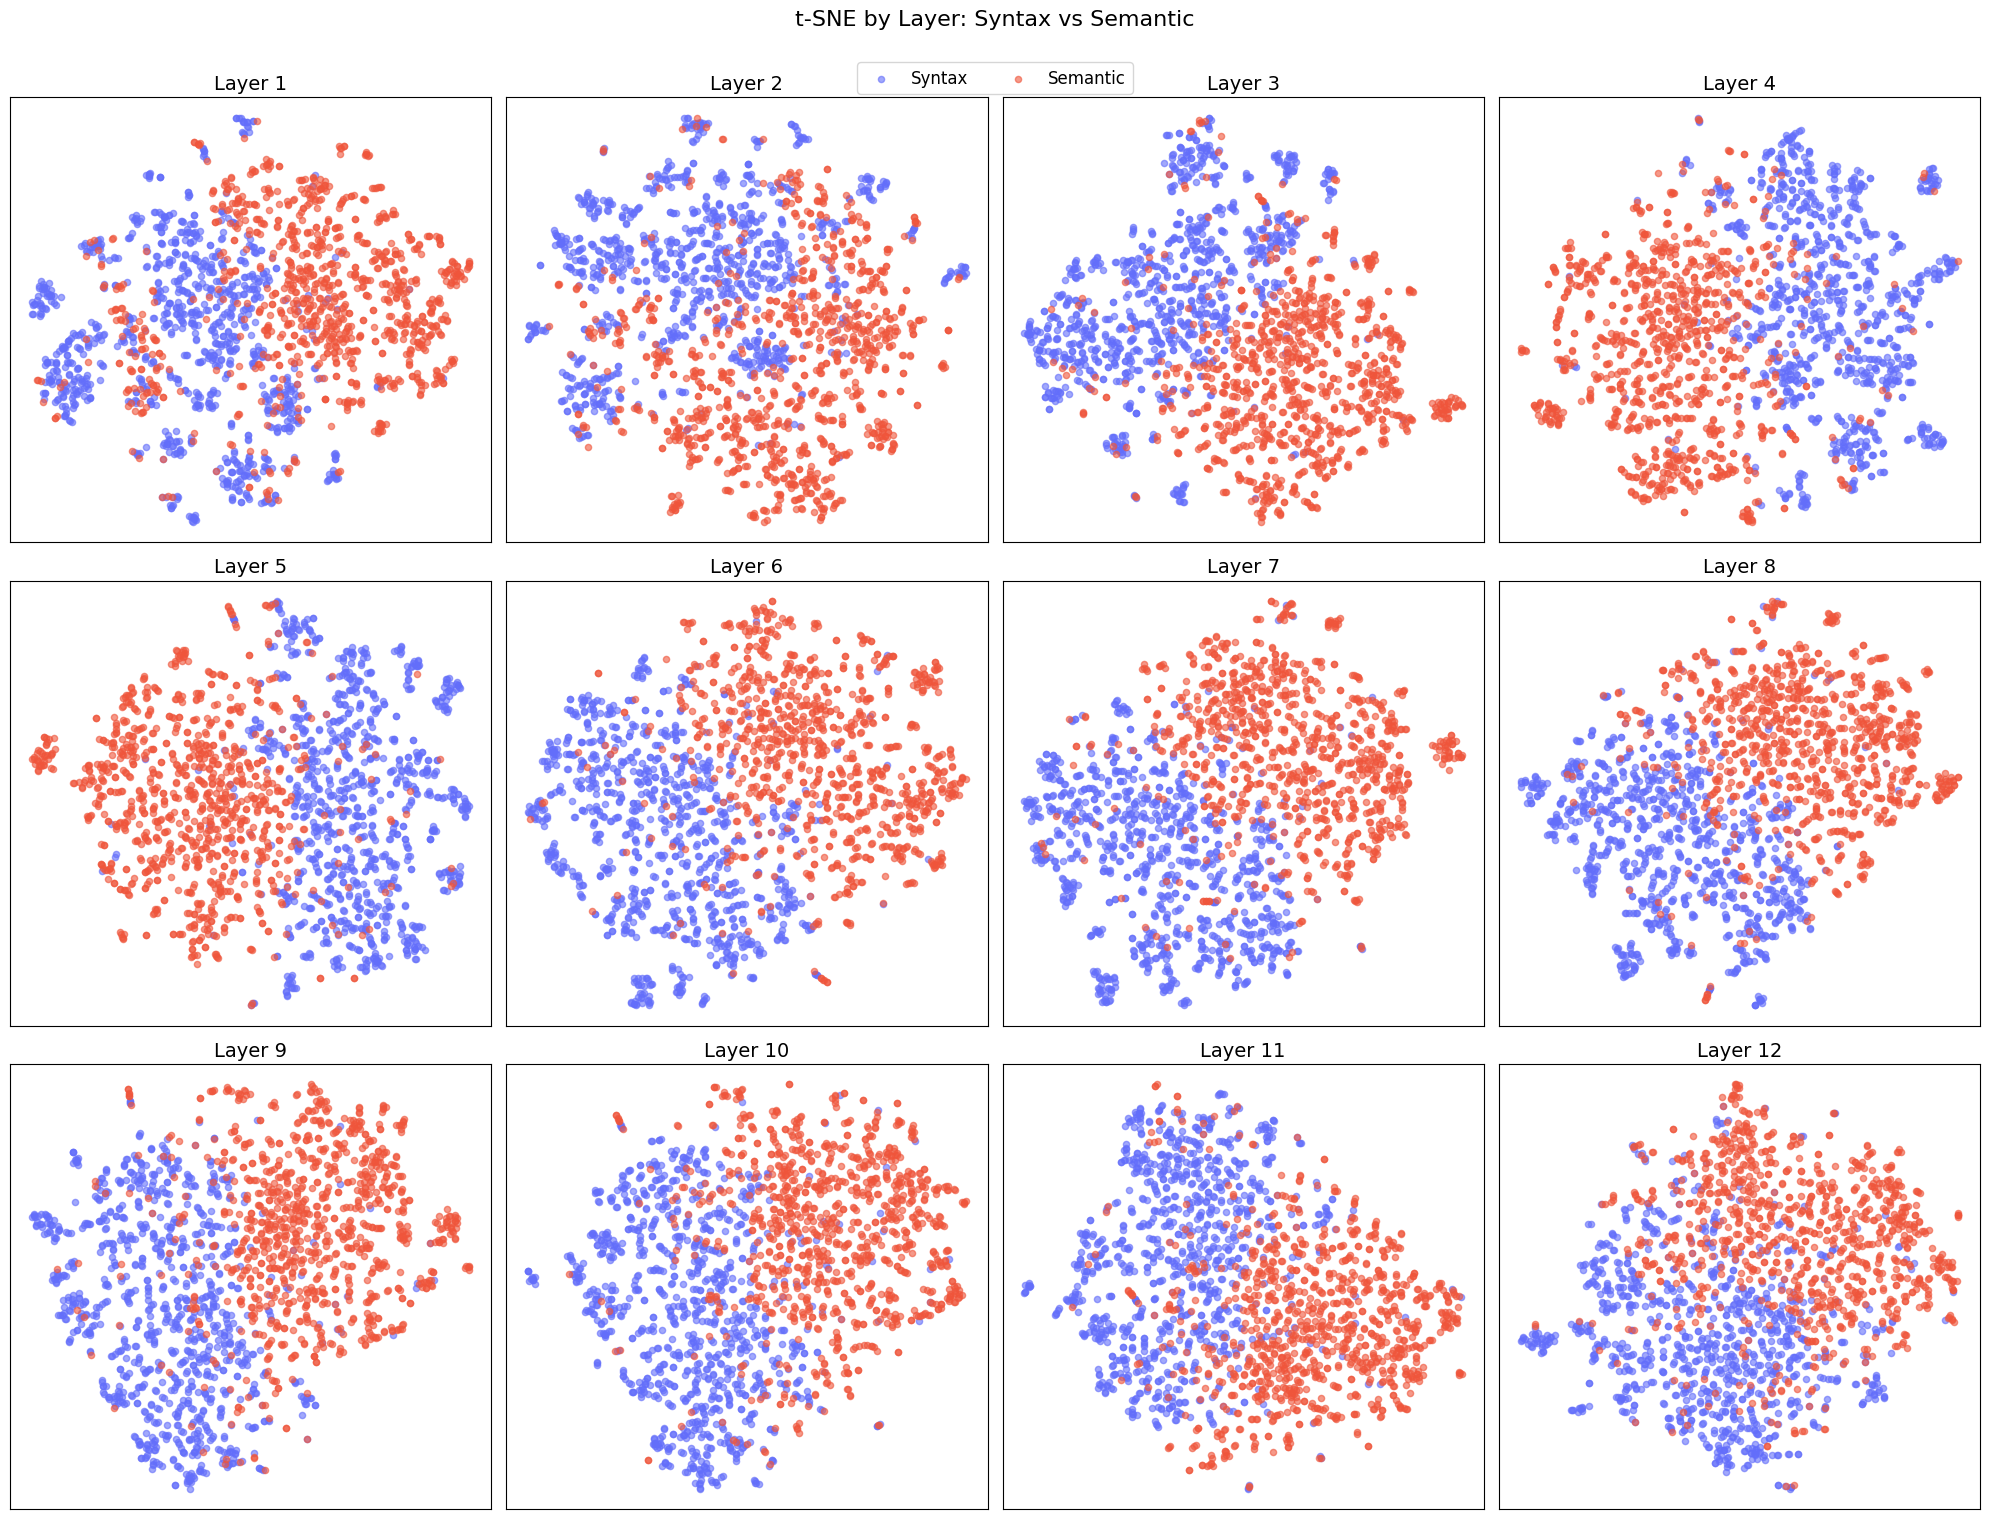

In [27]:
def plot_tsne_all_layers(final_samples_df, n_pca_components=100, perplexity=10, random_state=42):
    """
    Grid 3x4 with 2D t-SNE 2D for all 12 layer.
    """
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    labels = np.array(['Syntax'] * 1000 + ['Semantic'] * 1000)
    colors = {'Syntax': '#636EFA', 'Semantic': '#EF553B'}
    
    for i, ax in enumerate(axes):
        layer_num = i + 1
        layer_name = f'language_layer_{layer_num}'
        
        # Load embedding
        emb = collect_embeddings(final_samples_df, layer_name)
        
        # Stand + PCA
        scaler = StandardScaler()
        emb_scaled = scaler.fit_transform(emb)
        
        pca = PCA(n_components=n_pca_components, random_state=random_state)
        emb_pca = pca.fit_transform(emb_scaled)
        
        # t-SNE 2D
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
        coords = tsne.fit_transform(emb_pca)
        
        # Plot
        for label in ['Syntax', 'Semantic']:
            mask = labels == label
            ax.scatter(coords[mask, 0], coords[mask, 1], 
                      c=colors[label], label=label, alpha=0.6, s=20)
        
        ax.set_title(f'Layer {layer_num}', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Legenda unica
    handles, lbls = axes[0].get_legend_handles_labels()
    fig.legend(handles, lbls, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.98))
    
    plt.suptitle('t-SNE by Layer: Syntax vs Semantic', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.savefig('VIZ/tsne_all_layers.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig

fig = plot_tsne_all_layers(final_samples_df)